In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import least_squares

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    c = 300000
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
        
    #central_vel = c*z
    #lower_bounds = [0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,-np.inf,-np.inf]
    #upper_bounds = [np.inf,np.inf,central_vel + 500,400,np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf,central_vel + 1000,4100,np.inf,np.inf,central_vel + 1000,4100,np.inf,np.inf]
    #bounds_p_init = (lower_bounds,upper_bounds)
    #res = least_squares(full_gauss,x0=p_init,bounds=bounds_p_init,args=(wo_wave[select],data[select],error[select]),max_nfev = 10000000)
    #popt_full_fit = res['x']
        
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    v_out = [popt_full_fit[2] - popt_full_fit[6]]
    parameters = np.append(popt_full_fit,v_out)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(parameters),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        v_out_MC = [popt_MC[2] - popt_MC[6]]
        par_MC = np.append(popt_MC,v_out_MC)
        parameters_MC[:,l]=par_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error,v_out_error) = parameters_err
    return parameters,parameters_err 

In [4]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit) = popt_full_fit
    par_full_fit = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit]
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(par_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='black',label='data',drawstyle='steps-mid',lw = 3)
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)",fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_data.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='--',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_BLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(wo_wave[select],fit,'r:',label='fit')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_residual.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)


In [5]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    #print central_coordinates
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'central_x':19,'central_y':20}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)

def source_central_tab(obj,z,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_agncentral_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)


In [6]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/media/rickeythecat/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    #print brightest_pixel_x,brightest_pixel_y
    mini_data = wo_cube[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2]
    mini_error = wo_err[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2]
    (data,error) = int_spec(mini_data,mini_error)
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    #print (factor)
    error = factor*error
    #print (~np.isnan(error)).sum(0)
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)
    source_central_tab(obj,z)


HE0021-1810
[ 2.14648312e-01  2.86702146e+00  1.61063547e+04  1.03996920e+02
  1.56976221e-01  1.86674640e+00  1.60234356e+04  2.93220448e+02
  2.33489053e-01  2.17964012e-01  1.06254260e+04  2.23424964e+03
  0.00000000e+00  0.00000000e+00  1.59590000e+04  1.00000000e+03
  1.70864241e-01 -6.44627505e-02  8.29190957e+01] [6.12275035e-02 2.05103779e-01 5.33070684e+00 8.87098276e+00
 4.19156007e-02 2.12135963e-01 9.30786738e+00 1.64367042e+01
 3.36760548e-02 2.20118988e-02 1.35660268e+02 8.99955452e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.34279006e-01 7.13398968e-01 1.05090556e+01]


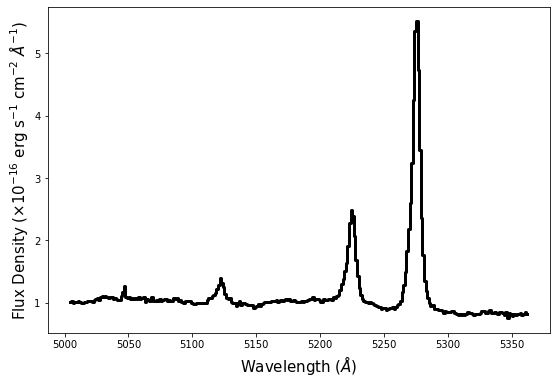

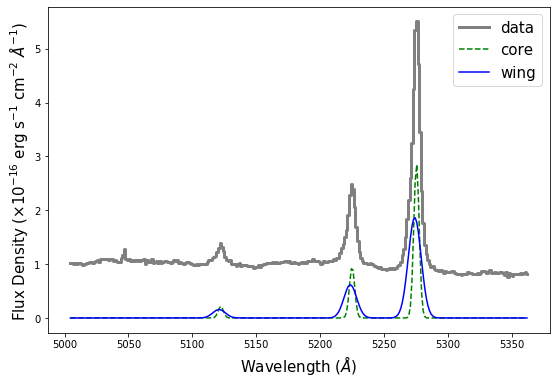

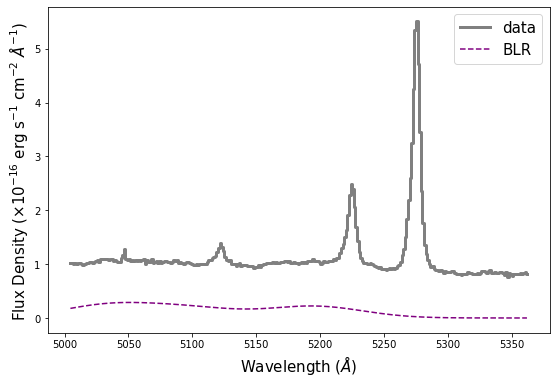

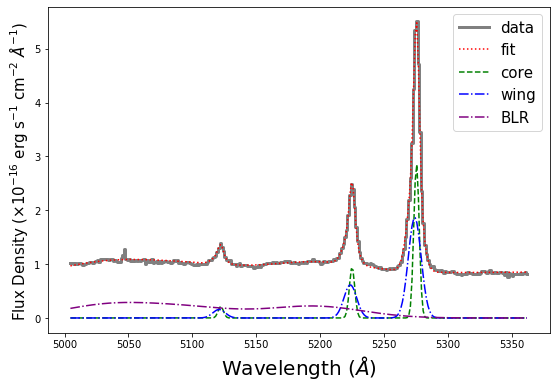

No handles with labels found to put in legend.


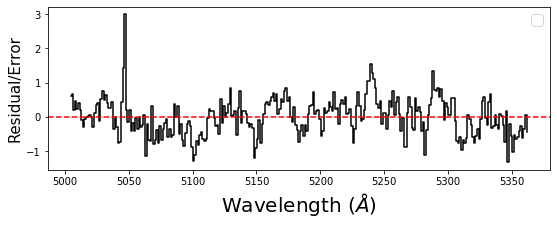

HE0021-1819
[ 9.81576536e-01  1.26120190e+01  1.59592107e+04  7.26016653e+01
  3.65214339e-01  2.46222746e+00  1.58062689e+04  2.93350513e+02
  4.36770879e-01  4.76799580e-02  1.59765303e+04  1.59937992e+03
  0.00000000e+00  0.00000000e+00  1.59590000e+04  1.00000000e+03
 -1.76375252e-01  1.38368172e+00  1.52941847e+02] [1.09479395e-02 3.69420024e-02 2.80688212e-01 4.47108961e-01
 6.59596140e-03 1.99625876e-02 1.59668350e+00 1.28240883e+00
 2.50248071e-03 2.63695701e-03 9.96651425e+00 1.02982319e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.25459278e-03 3.22636798e-02 1.63520218e+00]


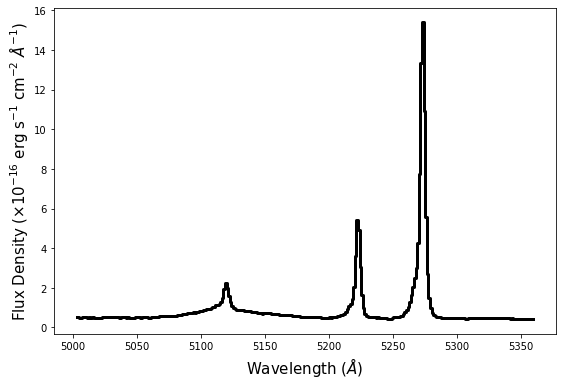

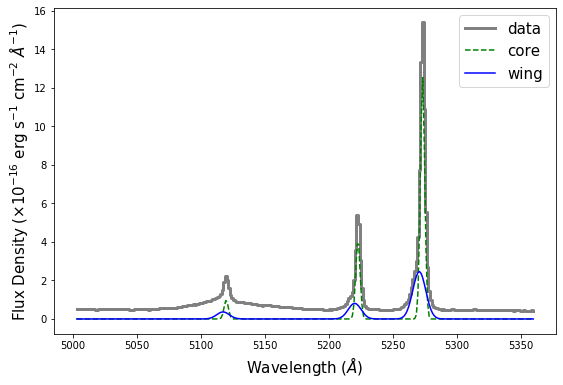

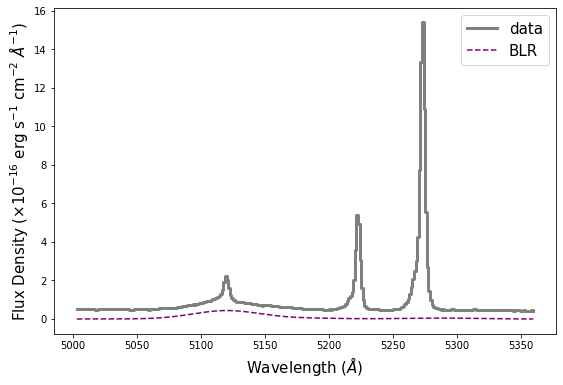

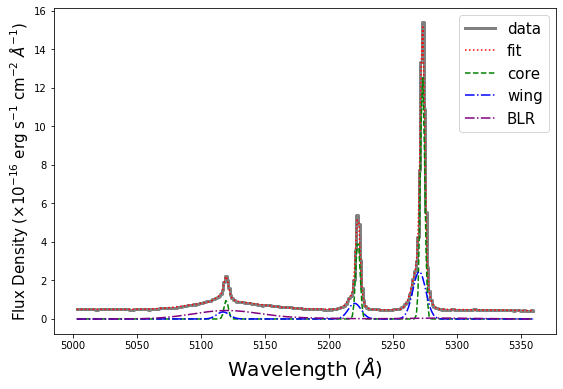

No handles with labels found to put in legend.


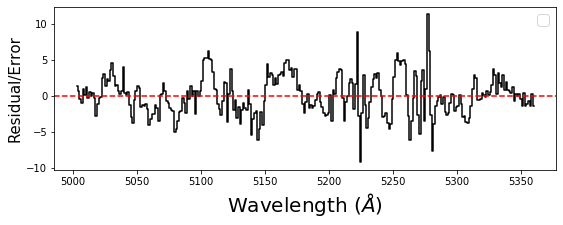

HE0040-1105
[1.71230197e+00 1.95481792e+01 1.25608517e+04 7.61265502e+01
 7.74033249e-01 4.25010435e+00 1.24125954e+04 2.51223640e+02
 2.58448639e+00 3.44095336e-01 1.29211098e+04 1.19457382e+03
 0.00000000e+00 0.00000000e+00 1.25070000e+04 1.00000000e+03
 1.13688295e-03 1.22195133e+00 1.48256342e+02] [0.03507014 0.07685402 0.39037322 0.54657594 0.02319378 0.05313589
 1.98823614 1.65489806 0.00835241 0.0043296  3.96964191 3.59062055
 0.         0.         0.         0.         0.01343114 0.06803786
 2.0059641 ]


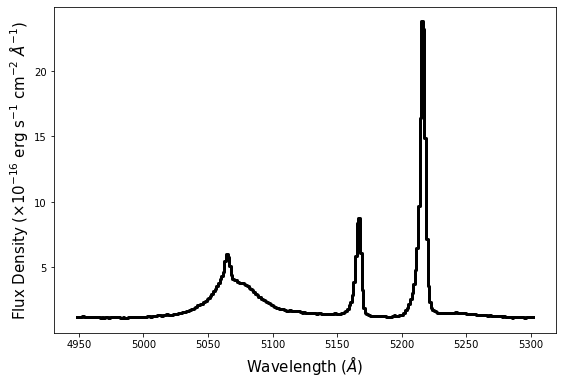

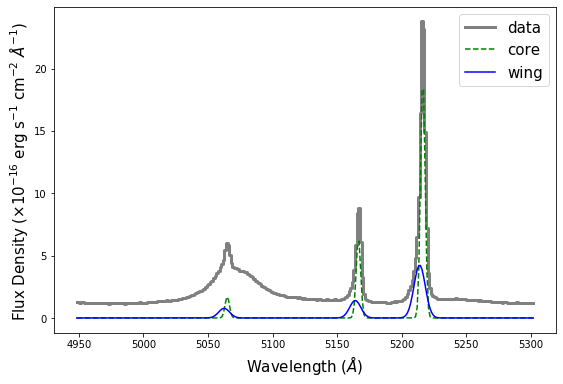

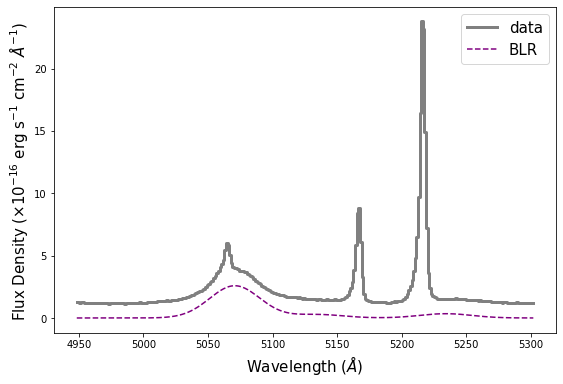

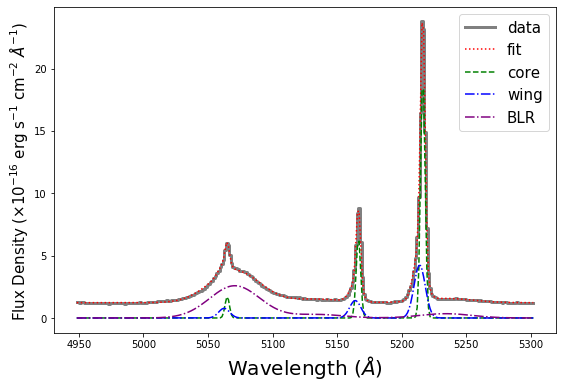

No handles with labels found to put in legend.


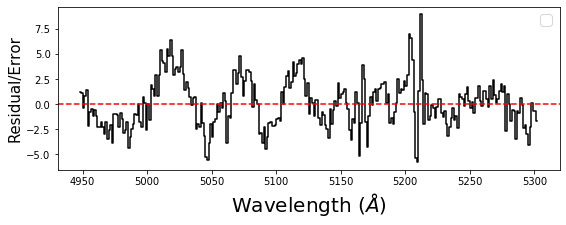

HE0108-4743
[ 2.44690856e+00  6.43270495e+00  7.16022278e+03  4.88684935e+01
  3.13834540e-01  3.32533784e+00  7.09832970e+03  1.25061293e+02
  4.25916737e-01  9.39371102e-02  7.07547675e+03  1.51426471e+03
  1.82901522e+00  3.12343759e-01  7.17130052e+03  4.64721159e+02
 -2.43413131e-01  2.63504814e+00  6.18930878e+01] [1.33934324e-01 5.05444447e-01 2.60713771e+00 5.37781824e+00
 1.60355484e-01 5.21386553e-01 7.77685392e+00 7.04210736e+00
 4.53039474e-02 1.56687179e-02 5.53089753e+01 1.07418672e+02
 5.26173529e-02 1.83492739e-02 6.94905013e+00 1.49253485e+01
 3.48001730e-02 1.76514333e-01 6.65056895e+00]


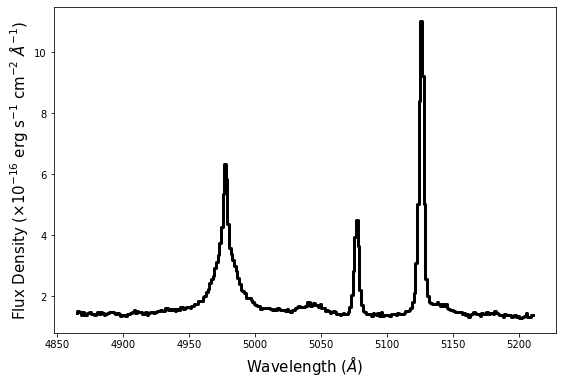

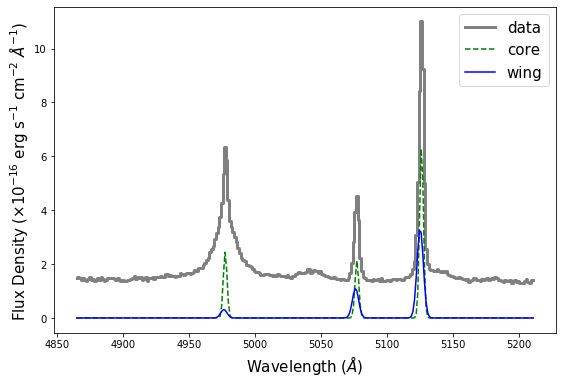

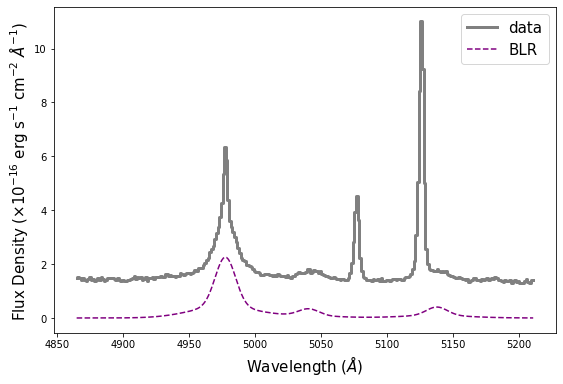

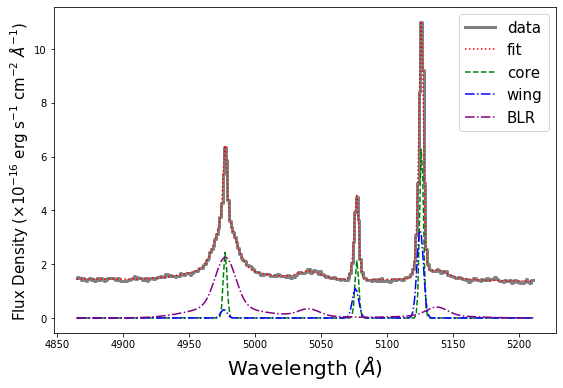

No handles with labels found to put in legend.


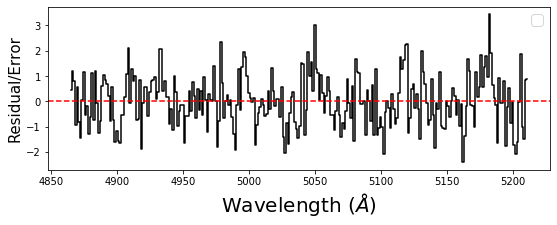

HE0114-0015
[ 1.92162980e+00  3.11879221e+00  1.36698635e+04  1.16946453e+02
  1.06298556e-01  2.94428256e-01  1.36242869e+04  3.60719229e+02
  7.16256018e-01  2.26490294e-01  1.36932304e+04  1.19847030e+03
  0.00000000e+00  0.00000000e+00  1.36800000e+04  1.00000000e+03
 -1.59083096e-01  1.43701998e+00  4.55766159e+01] [3.83724146e-02 3.95919267e-02 1.36328150e+00 1.58586825e+00
 3.69422091e-02 3.29009501e-02 2.32304497e+01 1.88754111e+01
 1.26566433e-02 4.73026539e-03 9.51157089e+00 1.49512512e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.35019195e-02 6.92922790e-02 2.41384353e+01]


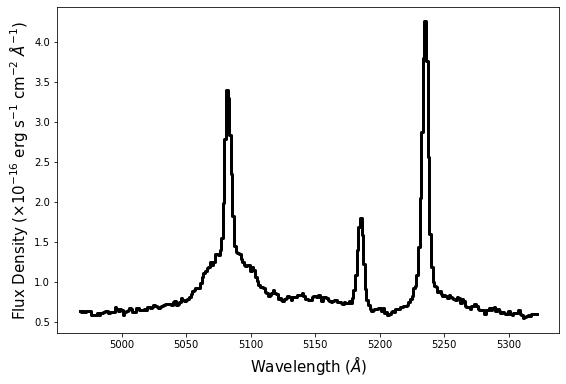

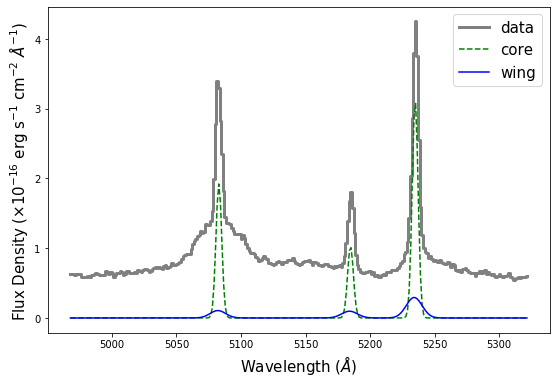

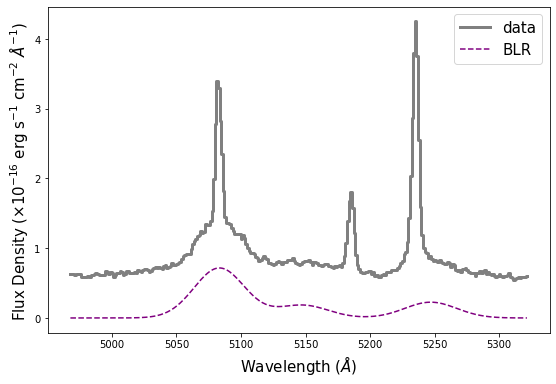

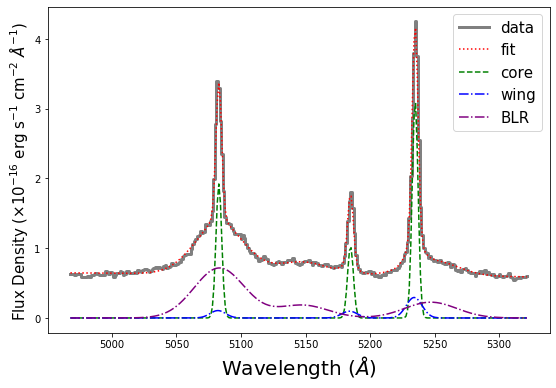

No handles with labels found to put in legend.


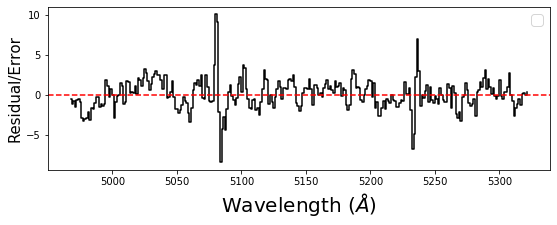

HE0119-0118
[ 2.03141426e+00  1.76251266e+01  1.63337617e+04  1.10936302e+02
  6.32949485e-01  1.17813870e+01  1.61236934e+04  2.46980380e+02
  2.06382892e+00  1.00218878e-01  1.65702589e+04  9.94120319e+02
  2.00065287e+00  5.34603213e-01  1.61983920e+04  2.35812718e+03
 -2.44664033e+00  1.61216509e+01  2.10068378e+02] [1.02621952e-01 2.93347134e-01 1.74522594e+00 2.38760148e+00
 1.03155020e-01 2.92371908e-01 4.76195085e+00 2.07838201e+00
 1.04527830e-01 3.90902815e-02 2.89149049e+01 5.33468023e+01
 1.26569908e-01 3.75905441e-02 6.67942317e+01 7.51382450e+01
 9.73943851e-02 5.13133530e-01 3.92766446e+00]


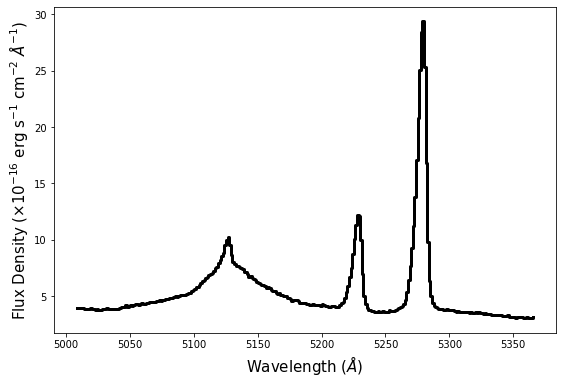

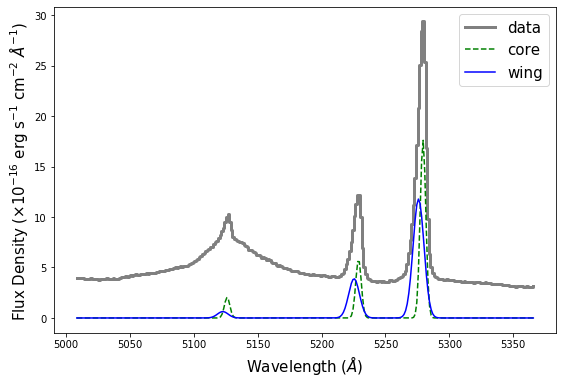

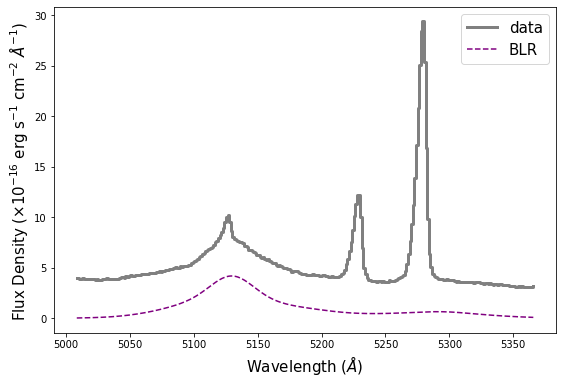

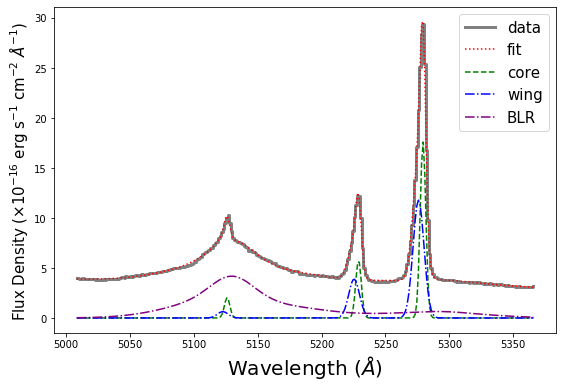

No handles with labels found to put in legend.


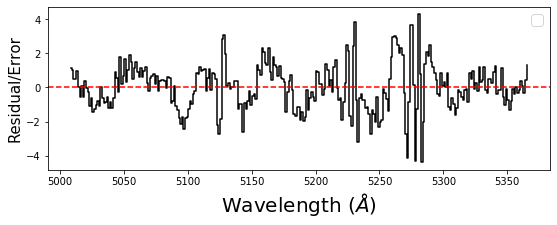

HE0212-0059
[1.07515320e+00 1.54110660e+01 7.92376238e+03 1.67027988e+02
 3.54647917e-01 1.42577828e+00 7.64148988e+03 4.54413647e+02
 1.71719859e+00 3.46100472e-01 7.77416778e+03 3.99381763e+03
 6.71212569e-01 3.19117598e-01 4.71152577e+03 1.13368247e+03
 2.52748889e-01 5.34470134e-01 2.82272500e+02] [1.81877907e+00 2.08783776e+01 3.56163382e+01 5.11661726e+01
 1.54056625e+02 2.15240521e+01 9.43733539e+02 5.41130131e+02
 1.11106696e+01 5.14083785e+00 1.92486231e+03 1.10462190e+03
 1.54491137e+02 5.09758272e+00 8.88591834e+02 1.16986074e+03
 2.11028192e+00 1.07079768e+01 9.45010238e+02]


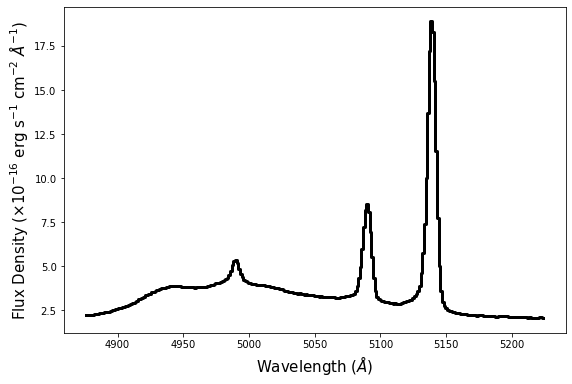

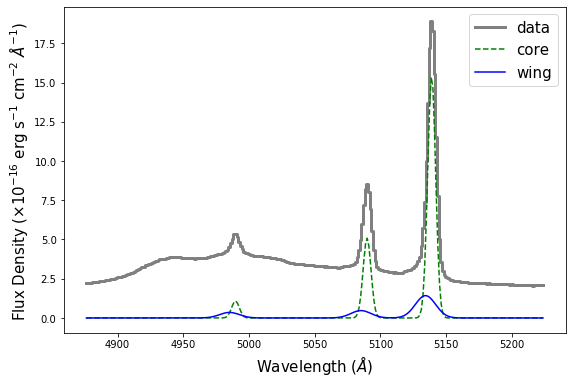

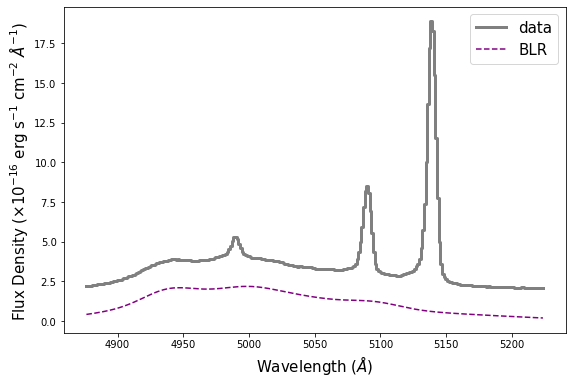

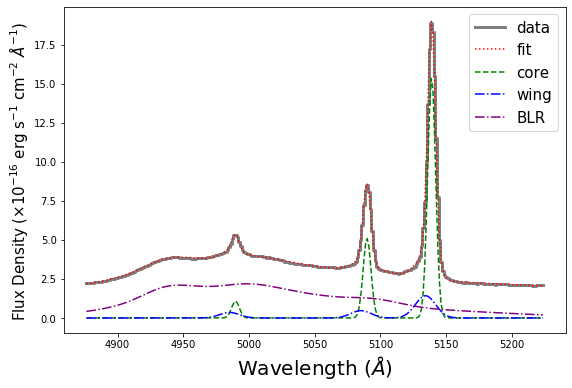

No handles with labels found to put in legend.


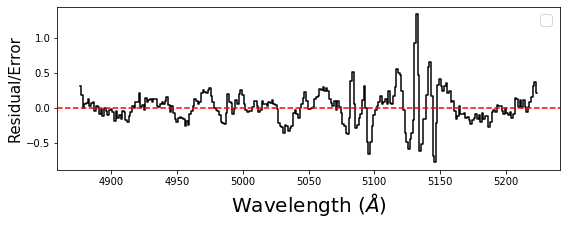

HE0224-2834
[ 2.72343096e-01  3.48363249e+00  1.79898937e+04  1.05300341e+02
  1.40206561e-01  1.49814485e+00  1.79656985e+04  2.56864033e+02
  5.39292847e-01  7.26195703e-02  1.80096399e+04  2.22702656e+03
  0.00000000e+00  0.00000000e+00  1.79400000e+04  1.50000000e+03
 -1.32041218e-01  1.24023558e+00  2.41951708e+01] [3.13770155e-02 1.27077100e-01 1.17878664e+00 3.91651509e+00
 2.52425944e-02 1.38631812e-01 3.85158830e+00 8.28779369e+00
 4.62682172e-03 4.64889751e-03 2.10827170e+01 2.68859470e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.35329058e-02 7.06138090e-02 4.37562804e+00]


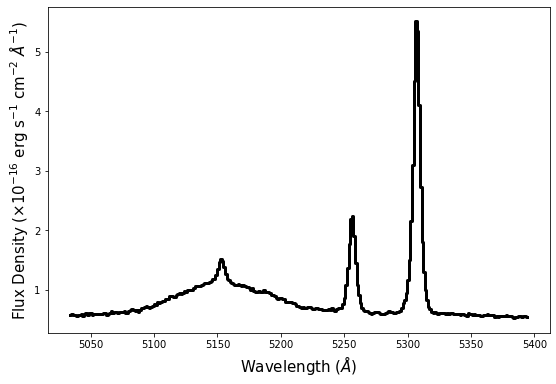

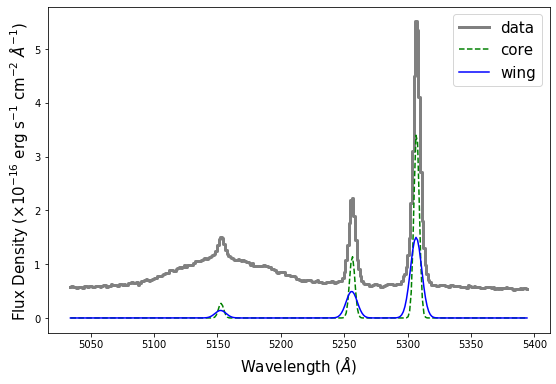

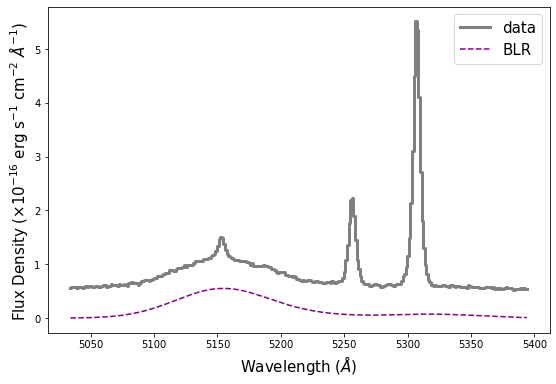

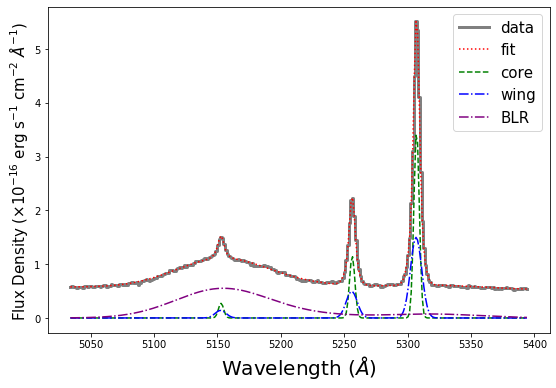

No handles with labels found to put in legend.


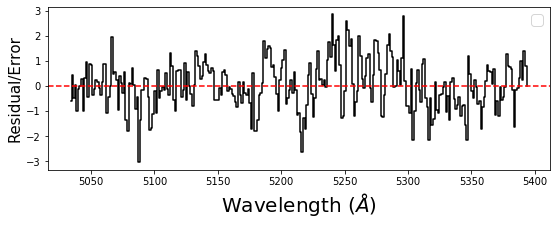

HE0227-0913
[ 4.40959209e+00  8.48888715e+00  4.78572765e+03  1.36855813e+02
  2.80139002e+00  9.75583898e-01  4.38751794e+03  3.11144257e+02
  1.02093742e+01  2.57046207e+00  4.90963967e+03  3.97355773e+02
  4.71487956e+00  6.77805847e-01  4.70644637e+03  1.31689724e+03
 -5.66956173e-01  7.37943130e+00  3.98209716e+02] [ 0.08932284  0.03399702  0.8025174   1.18291487  0.07215509  0.03560697
 10.85823115  4.56073917  0.05802954  0.01405708  2.54456191  3.34295667
  0.05430161  0.01543394  3.47932541  8.99751445  0.020695    0.10435509
 10.35959478]


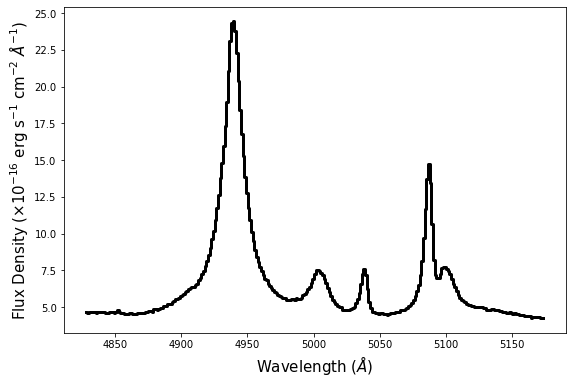

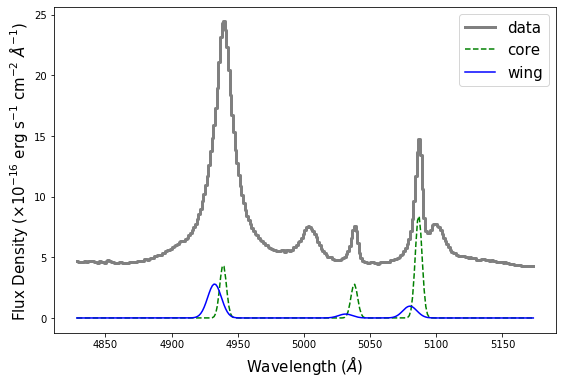

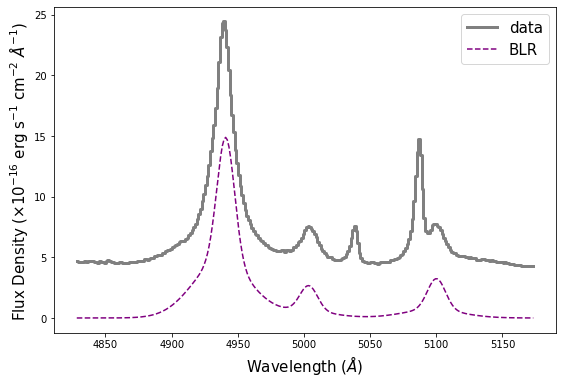

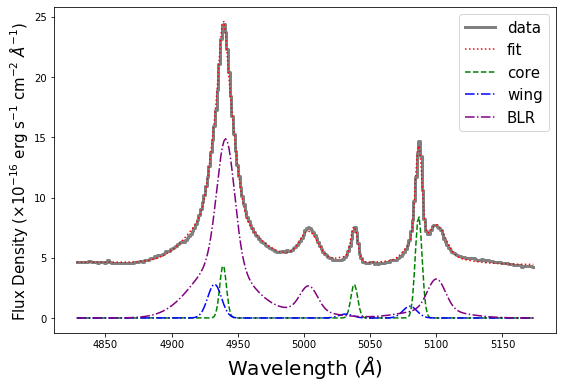

No handles with labels found to put in legend.


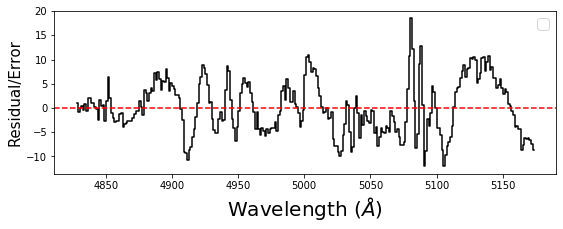

HE0232-0900
[ 5.85308916e+00  5.96831950e+01  1.29028269e+04  1.32082425e+02
  2.76365782e-01  2.79570130e+01  1.28219888e+04  2.86075336e+02
  1.25362633e+01  1.78086341e+00  1.29127519e+04  2.19749507e+03
  0.00000000e+00  0.00000000e+00  1.29420000e+04  1.00000000e+03
 -8.53587875e+00  5.75663590e+01  8.08381004e+01] [ 0.44065411  1.38643558  1.79874951  2.32638202  0.33785959  1.46357151
  3.71500474  5.40862502  0.07589757  0.06930157 13.52013319 13.25767765
  0.          0.          0.          0.          0.19217631  0.98803574
  4.00353743]


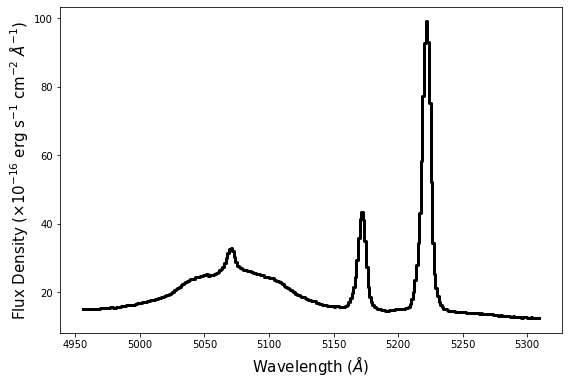

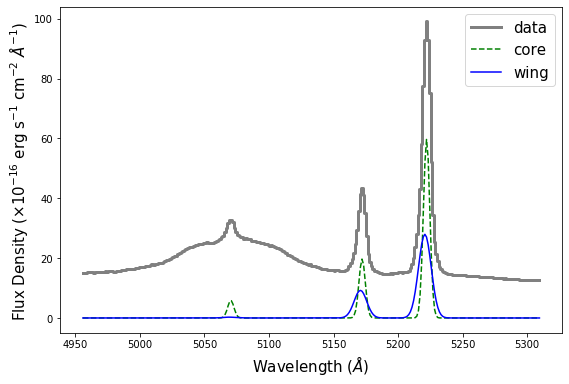

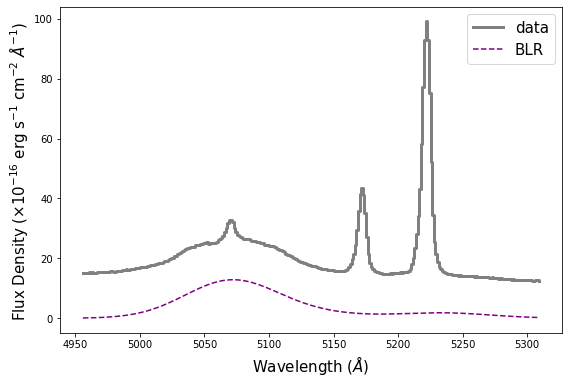

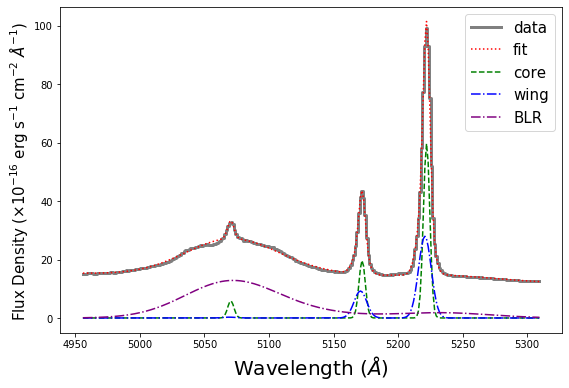

No handles with labels found to put in legend.


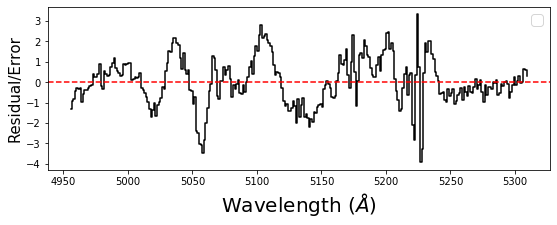

HE0253-1641
[2.57599558e+00 2.82510106e+01 9.54003559e+03 1.08803933e+02
 1.74871810e+00 9.82478353e+00 9.28334660e+03 3.71610356e+02
 2.38230266e+00 4.52468939e-01 9.18149872e+03 1.71883943e+03
 4.00996010e+00 1.14362432e+00 9.74558339e+03 5.50721488e+02
 3.75209757e-01 4.54576665e+00 2.56688988e+02] [ 0.12435673  0.19545768  0.91990283  1.58154767  0.13897157  0.16649841
  5.11810401  3.50429699  0.05815993  0.04894074 36.95801252 29.70551419
  0.10152564  0.04369703 12.2321254  11.98552846  0.07125391  0.36148422
  4.82719345]


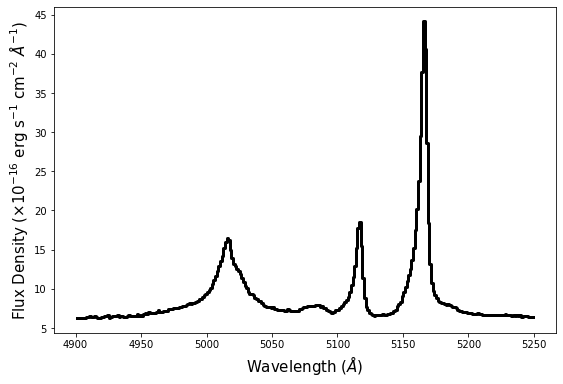

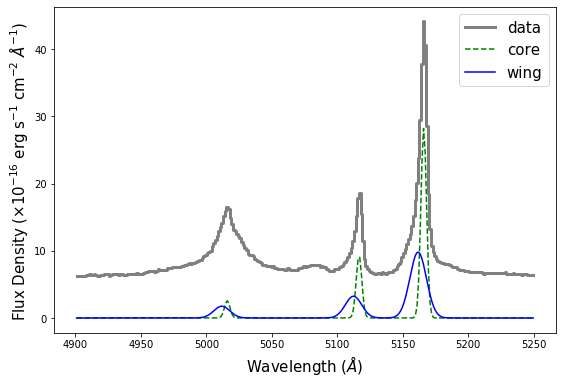

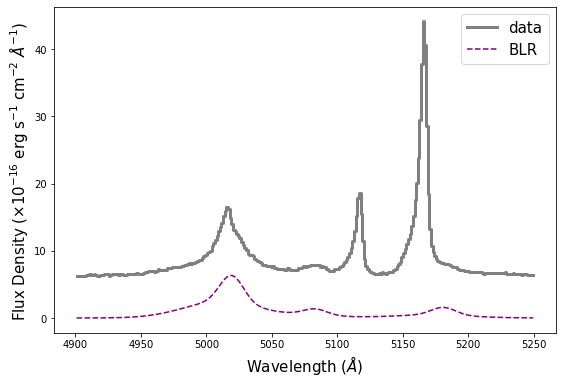

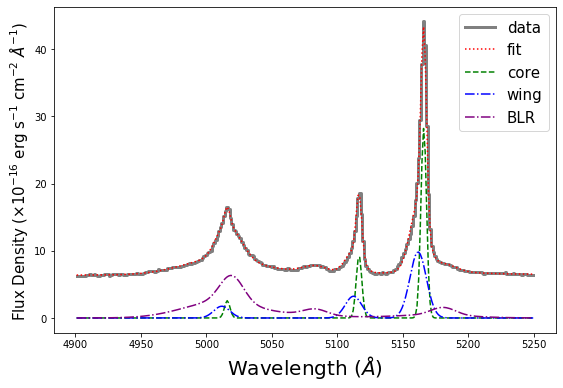

No handles with labels found to put in legend.


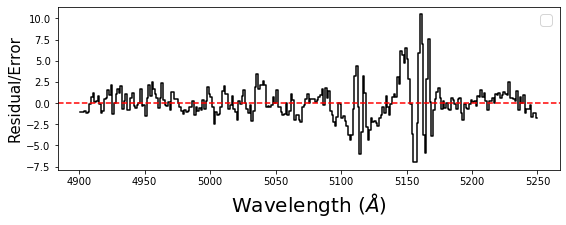

HE0345+0056
[ 1.57340529e+00  2.38077060e+01  9.18007101e+03  1.63578915e+02
  5.90040890e+00  1.58297723e+01  8.84612949e+03  3.93892786e+02
  3.74299303e+01  3.59047398e+00  9.34442775e+03  3.30867909e+02
  1.23369671e+01  2.45221730e+00  9.35228275e+03  1.51883363e+03
 -3.48663041e+00  2.99454029e+01  3.33941517e+02] [ 1.15162782  0.4599849   3.23104159  4.3475673   0.5037295   0.42731399
  9.69866508  4.13907175  0.91663942  0.09072377  6.45174247  4.91871103
  0.20786705  0.08171878 10.24230682 18.95048678  0.15236778  0.77704721
  8.51077797]


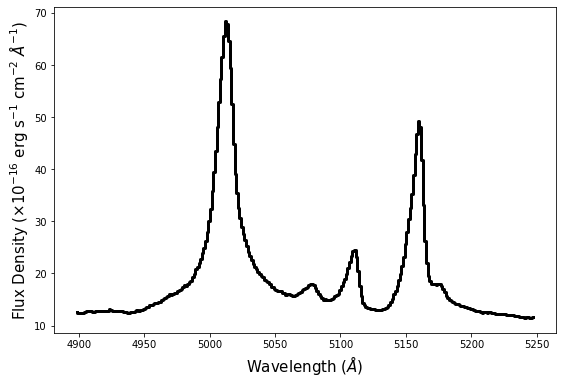

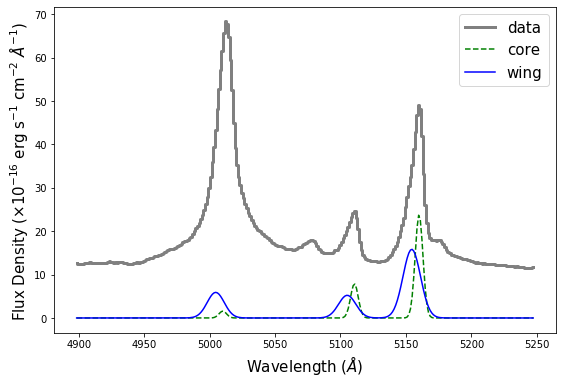

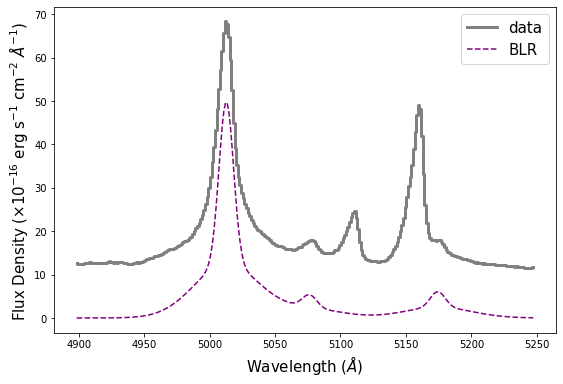

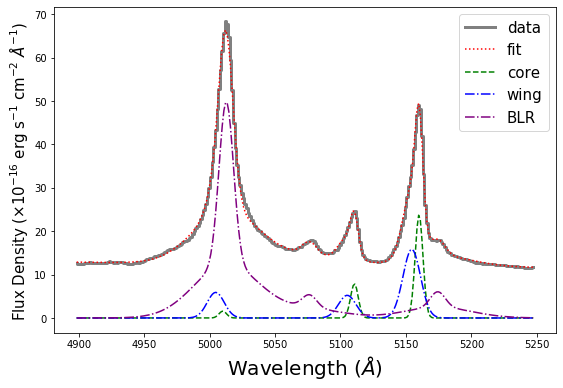

No handles with labels found to put in legend.


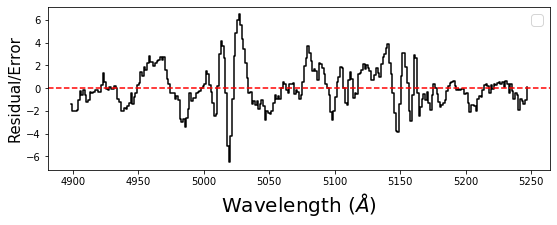

HE0351+0240
[ 3.31829317e+00  5.51673609e+01  1.06368882e+04  6.73077596e+01
  1.56955603e+00  2.63267508e+00  1.06210475e+04  2.52409804e+02
  2.25163016e+00  1.56267855e-01  1.15838805e+04  3.15838619e+02
  5.36997301e+00  5.12390254e-01  1.06501924e+04  1.31428583e+03
 -8.78687933e-01  7.05600539e+00  1.58407367e+01] [0.09551095 0.17951237 0.24898314 0.6120831  0.08467914 0.17865535
 3.48378828 8.60849826 0.05323744 0.01684497 6.62217535 6.51750086
 0.05302205 0.01336366 7.21905949 9.00376439 0.03426403 0.17553009
 3.62263201]


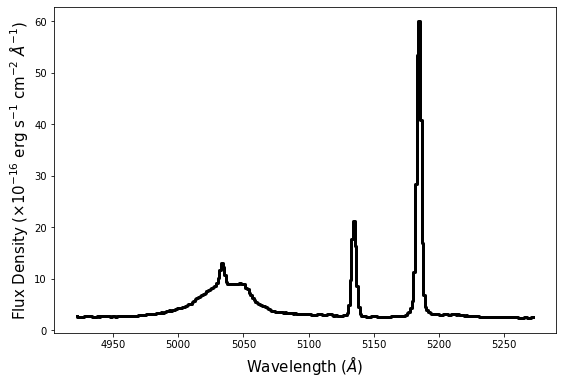

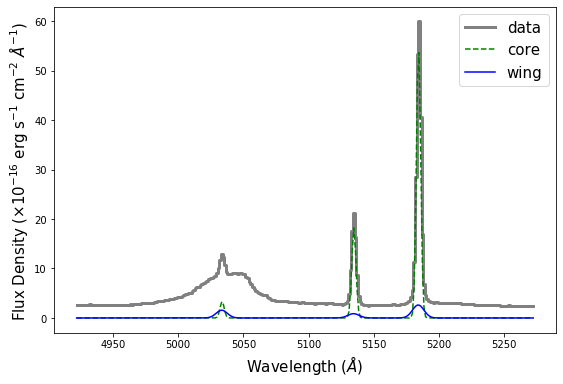

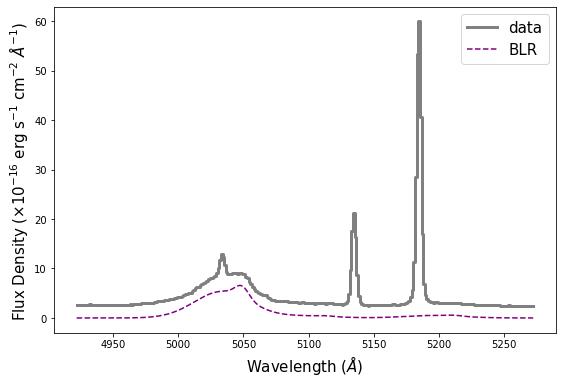

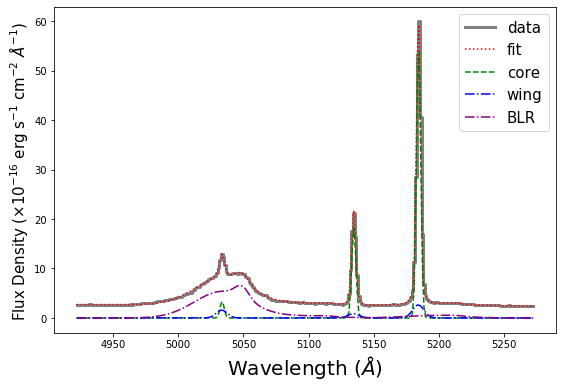

No handles with labels found to put in legend.


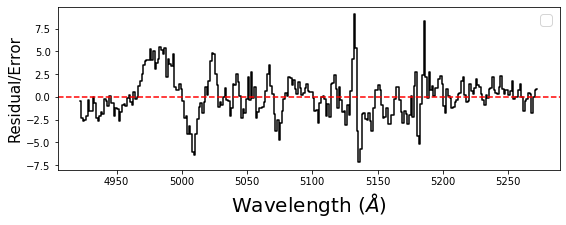

HE0412-0803
[ 1.29630572e+01  1.77321491e+02  1.14679421e+04  9.06529882e+01
  4.11028743e+00  3.49632660e+01  1.14591228e+04  2.68172923e+02
  1.13010815e+01  1.45308256e+00  1.13013029e+04  1.77475131e+03
  0.00000000e+00  0.00000000e+00  1.14480000e+04  1.00000000e+03
 -3.37375947e+00  2.49858776e+01  8.81925656e+00] [5.11493015e-01 1.59316925e+00 7.93459664e-01 4.19683309e+01
 8.69627626e-01 3.55013005e+00 1.19463612e+01 1.13747956e+02
 1.07781576e+00 1.33962270e-01 6.74330624e+02 3.25146614e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.70492729e-01 1.92298805e+00 1.19499334e+01]


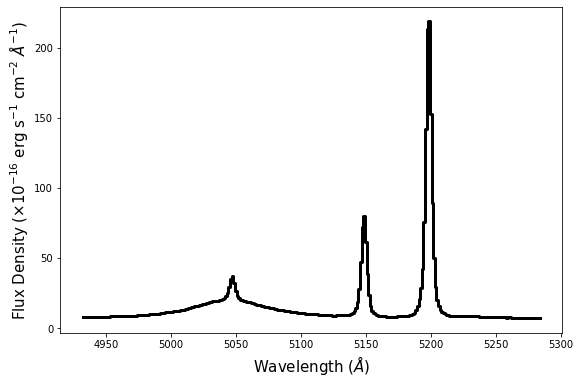

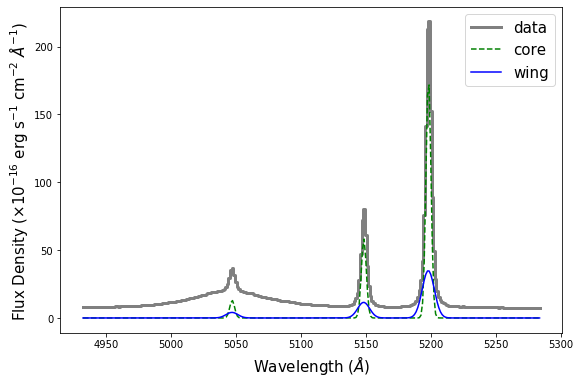

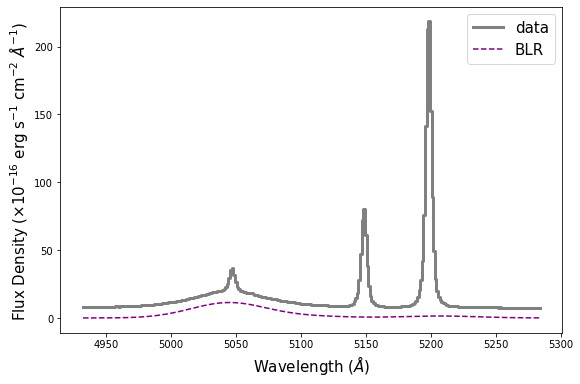

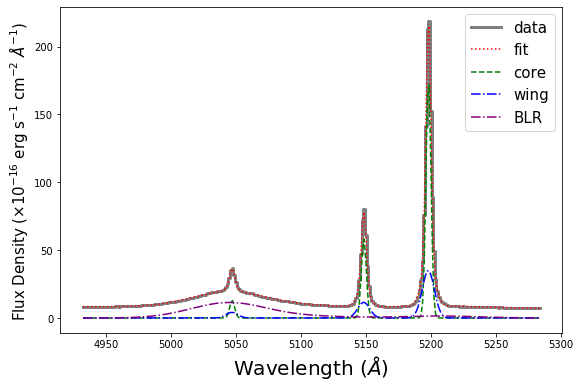

No handles with labels found to put in legend.


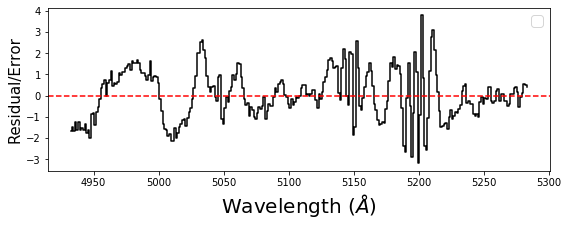

HE0429-0247
[ 1.88720136e+00  1.63767386e+01  1.26351263e+04  8.54416717e+01
 -2.49346425e-01  4.01878203e+00  1.25786815e+04  2.17384707e+02
  3.17360147e+00  1.28882753e-01  1.26490492e+04  4.83980028e+02
  2.45704305e+00  3.47922045e-01  1.26806619e+04  1.70457642e+03
 -1.61505511e+00  1.08813167e+01  5.64448122e+01] [8.11179664e-02 1.36196558e-01 4.50637567e-01 8.59372553e-01
 1.70867610e-01 1.38552839e-01 2.42704092e+00 2.70661081e+00
 9.45724305e-02 1.08960836e-02 3.27842199e+00 1.63045185e+01
 4.32226873e-02 9.56089529e-03 6.46109790e+00 1.76511161e+01
 2.05954012e-02 1.06130515e-01 2.52381887e+00]


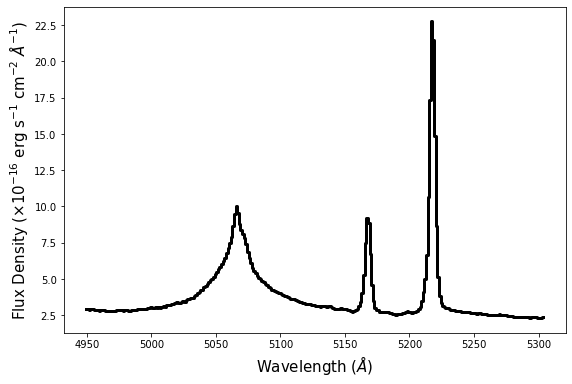

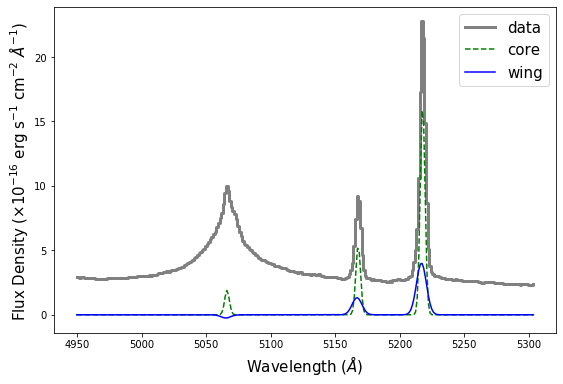

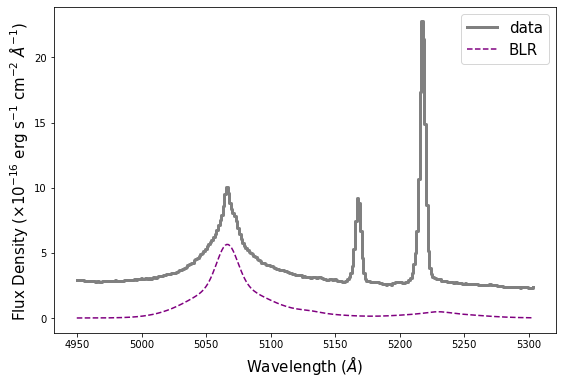

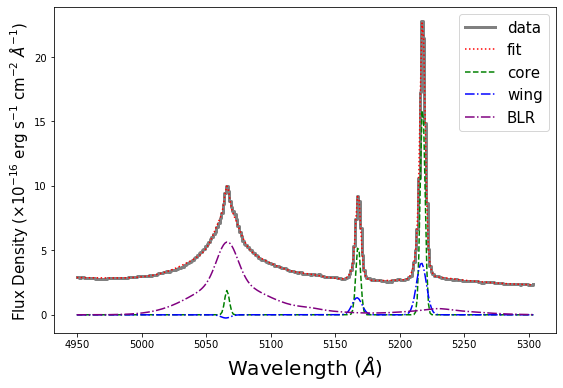

No handles with labels found to put in legend.


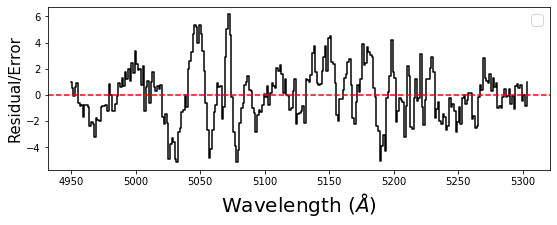

HE0433-1028
[ 5.12559727e+00  3.41059622e+01  1.05786844e+04  1.30179284e+02
  4.14738853e+00  3.89766334e+01  1.02705890e+04  3.35147521e+02
  1.91623719e+01  1.99802829e+00  1.05090076e+04  9.51521182e+02
  8.95090399e+00  2.60112259e+00  1.13312062e+04  2.16086384e+03
 -7.20647244e+00  5.06877329e+01  3.08095406e+02] [ 0.37426607  0.79915552  3.65794733  4.58501188  0.44403117  0.70956772
  5.34856252  2.51383076  0.28677588  0.09792406  9.24980893 21.04245323
  0.35783807  0.13155993 43.26595992 28.43826654  0.29772431  1.50258962
  4.08855573]


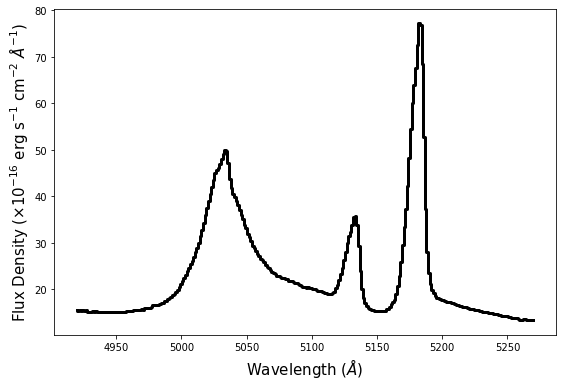

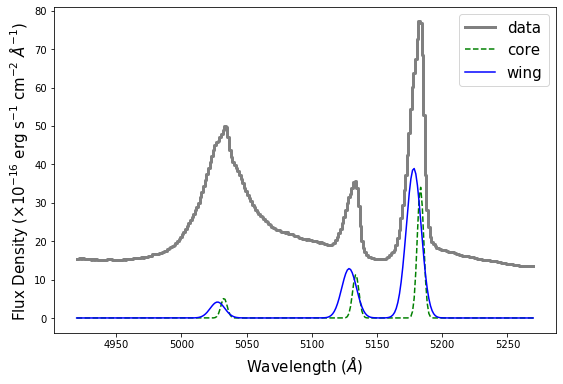

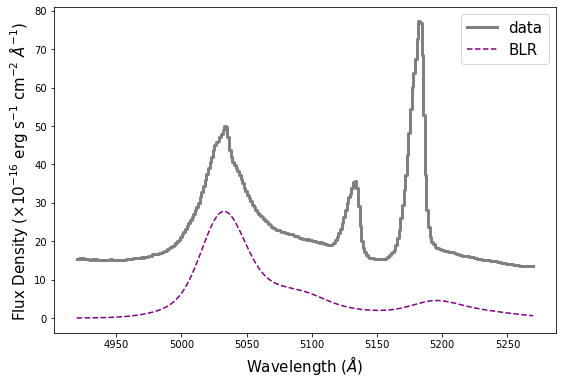

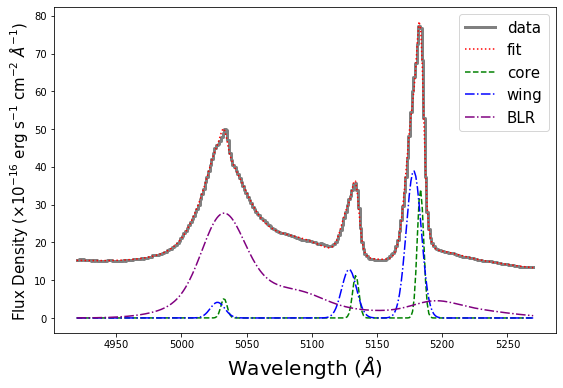

No handles with labels found to put in legend.


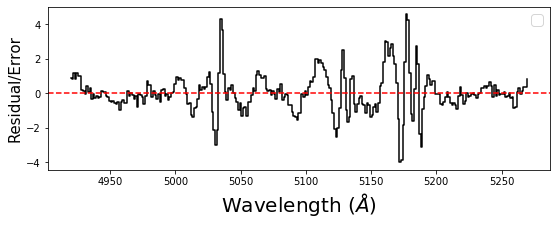

HE0853+0102
[5.11683754e-01 4.61587927e+00 1.57061845e+04 1.02496678e+02
 9.44998340e-02 1.35685502e+00 1.56603281e+04 3.14042380e+02
 7.64142659e-01 1.28978693e-01 1.59127646e+04 1.70812230e+03
 1.53105595e-01 8.52725336e-03 1.72227837e+04 8.02722528e+02
 3.06000223e-02 2.56163611e-01 4.58563746e+01] [2.73398670e-02 6.17669609e-02 9.30461048e-01 2.06905056e+00
 2.72573268e-02 6.69596890e-02 3.35300137e+00 8.15735288e+00
 7.15936715e-02 8.59544024e-03 4.77409573e+01 6.90130665e+01
 7.33681150e-02 1.15478873e-02 2.34212776e+02 2.65073077e+02
 1.26799557e-02 6.52868695e-02 3.67520600e+00]


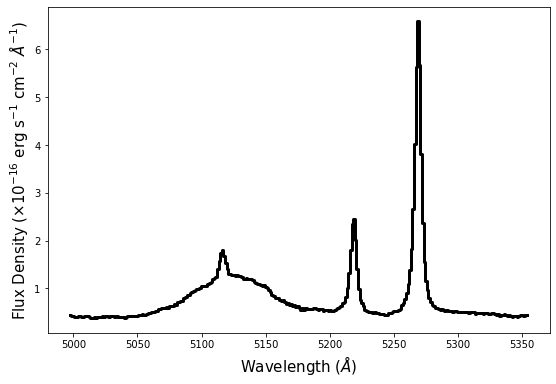

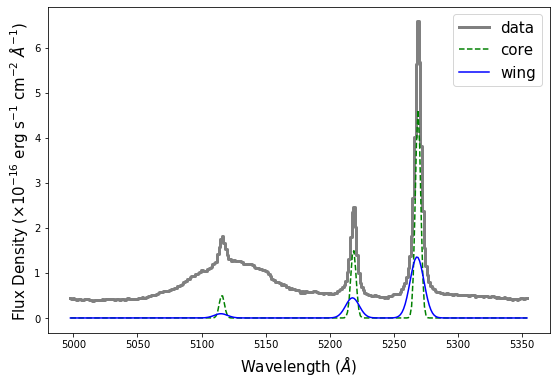

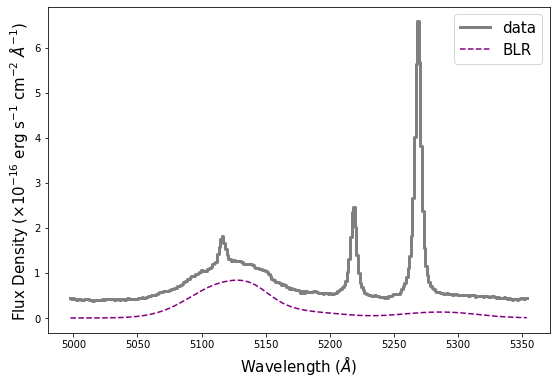

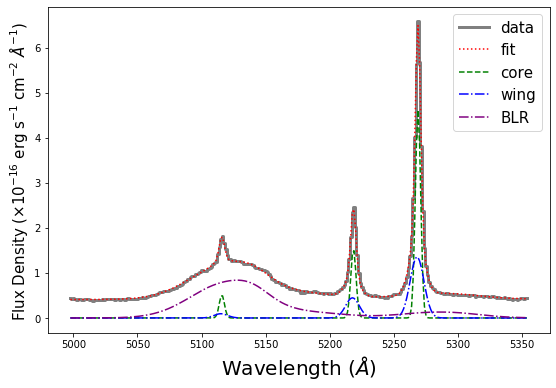

No handles with labels found to put in legend.


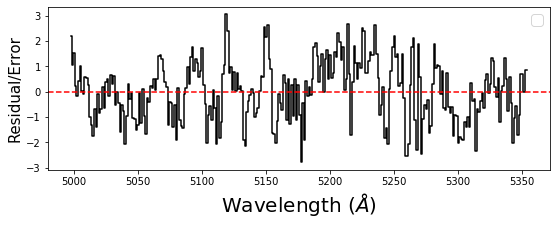

HE0934+0119
[ 1.84152038e+00  1.28348675e+01  1.52070791e+04  6.82978777e+01
  1.14466381e+00  6.37155990e+00  1.50763417e+04  1.66368651e+02
  5.91106325e+00  7.26643183e-01  1.52086476e+04  5.75572482e+02
  2.62472421e+00  3.89402988e-01  1.51846519e+04  1.43252041e+03
 -1.38967414e+00  1.09623394e+01  1.30737408e+02] [1.13679088e-01 2.41910979e-01 1.20350703e+00 1.95041684e+00
 1.24483213e-01 2.29654936e-01 5.21114223e+00 2.21736019e+00
 8.51943851e-02 1.74975475e-02 3.62425754e+00 1.03634268e+01
 1.10783140e-01 1.97610979e-02 9.74086462e+00 2.72235038e+01
 3.16221019e-02 1.64674316e-01 5.19616223e+00]


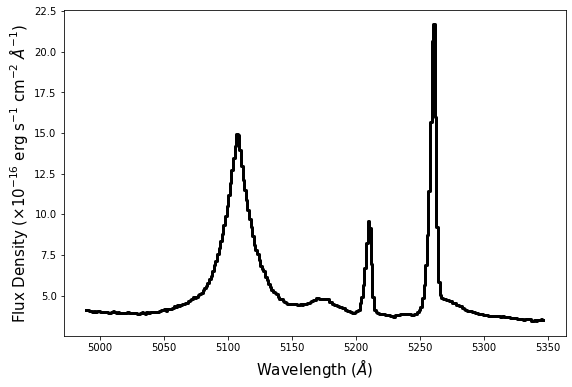

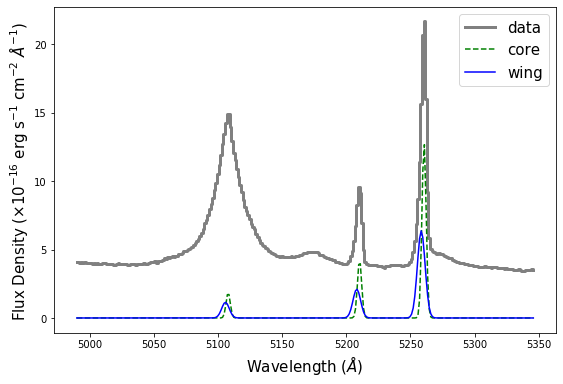

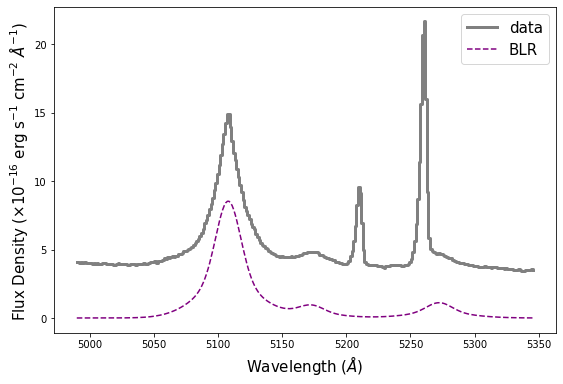

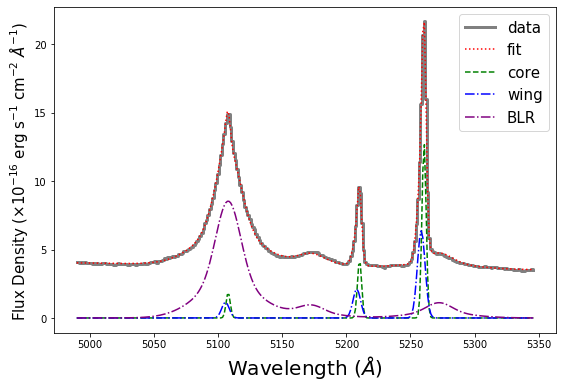

No handles with labels found to put in legend.


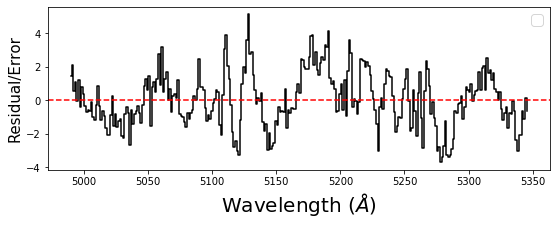

HE1011-0403
[ 1.18619777e+00  7.65646262e+00  1.75317091e+04  1.00877178e+02
  7.32543034e-01  4.26993079e+00  1.73192079e+04  2.57932577e+02
  2.16485744e+00  3.74908191e-01  1.77025336e+04  1.50787379e+03
  5.21157705e+00  5.70857229e-01  1.76826294e+04  7.98747284e+02
 -1.35771471e+00  1.26147342e+01  2.12501192e+02] [ 0.15768389  0.23174792  2.94911596  4.85910964  0.15573139  0.20520343
 12.58526066  5.70292884  0.39522782  0.11194255 42.29339742 88.14558285
  0.3521485   0.10644712 18.83911268 30.5844249   0.09233668  0.47785474
 12.17919699]


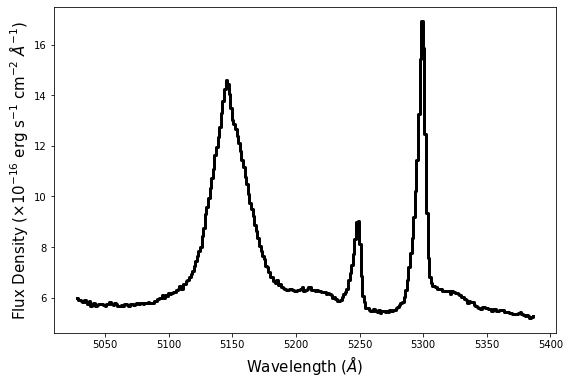

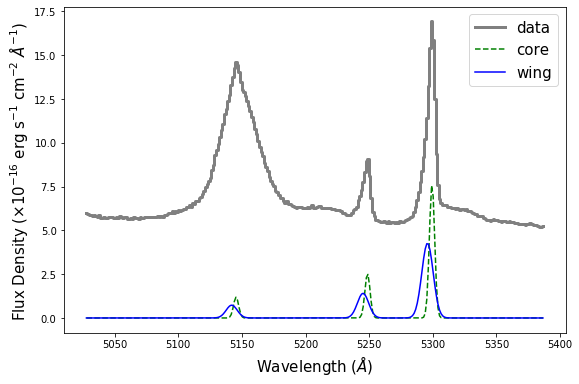

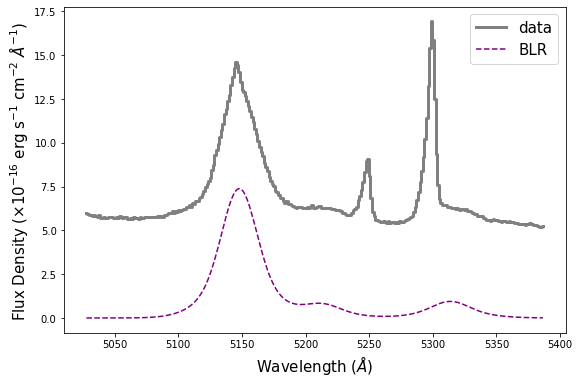

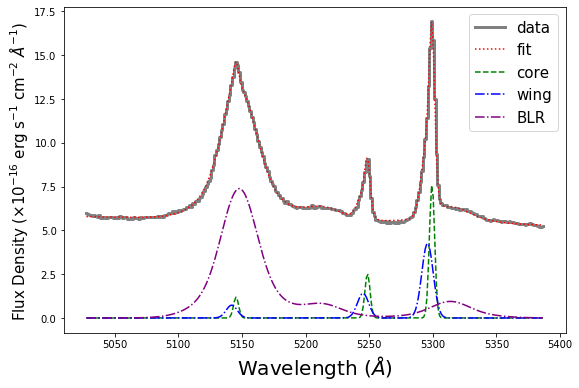

No handles with labels found to put in legend.


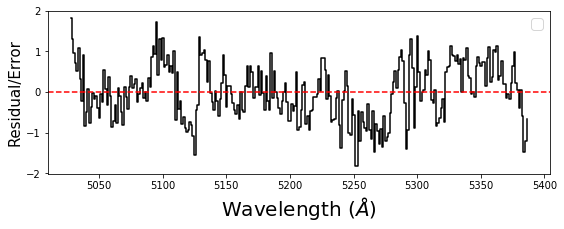

HE1017-0305
[ 5.87524676e-01  9.72425503e+00  1.46811520e+04  5.29653381e+01
  7.90473489e-01  2.91057961e+00  1.46191529e+04  2.05358253e+02
  4.58160057e+00  8.20960842e-01  1.45127511e+04  2.00035094e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.08839487e+00  1.47364142e+01  6.19991628e+01] [1.44892741e-01 2.96672858e-01 1.46208381e+00 4.33502045e+00
 1.17722526e-01 3.23878907e-01 8.53107359e+00 4.44504552e+01
 2.59452721e-02 2.15400389e-02 1.13593532e+01 1.36285850e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.89761097e-02 3.08158781e-01 8.49233033e+00]


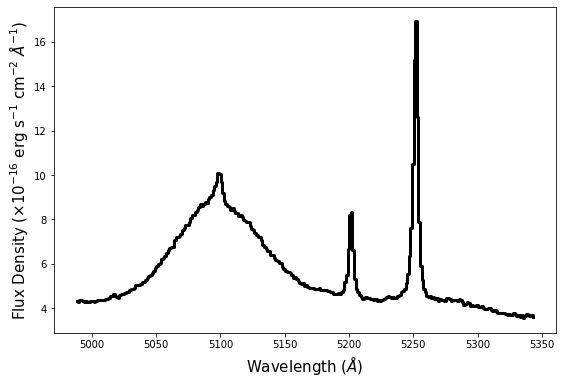

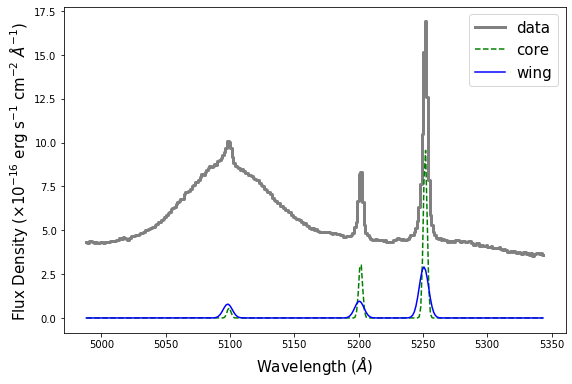

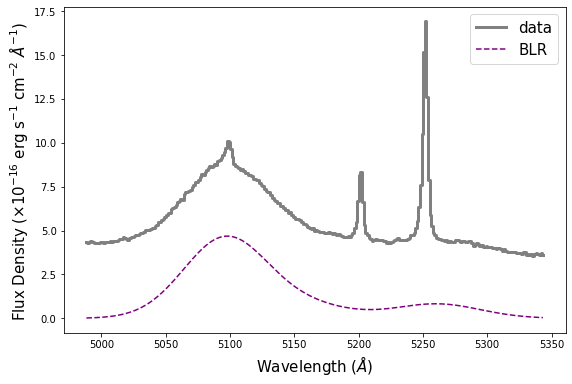

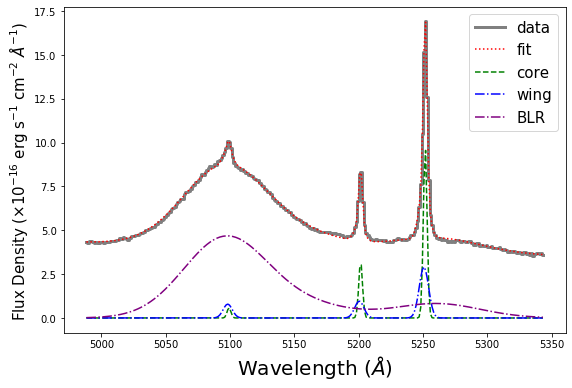

No handles with labels found to put in legend.


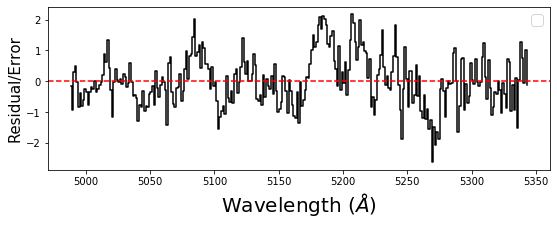

HE1029-1831
[ 4.97567153e+00  3.46653876e+00  1.21134528e+04  8.21000298e+01
  1.28270528e+00  8.96443556e+00  1.19934868e+04  2.25032669e+02
  1.78865966e+00  3.70715936e-01  1.21068083e+04  1.67879820e+03
  2.46537709e+00  4.03432227e-01  1.25357172e+04  8.86559723e+02
 -5.58075599e-01  7.06782185e+00  1.19965993e+02] [9.42639867e-02 2.18628603e-01 3.04883910e+00 3.52787409e+00
 2.30656184e-01 1.74976028e-01 2.70861887e+00 1.82506704e+00
 3.35007165e-01 8.97742957e-02 4.95133726e+01 9.09827253e+01
 2.81216961e-01 8.88962676e-02 9.65385283e+01 1.17036337e+02
 6.63428001e-02 3.42541896e-01 4.39316826e+00]


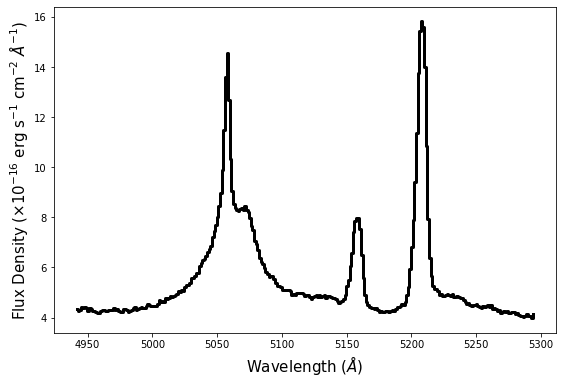

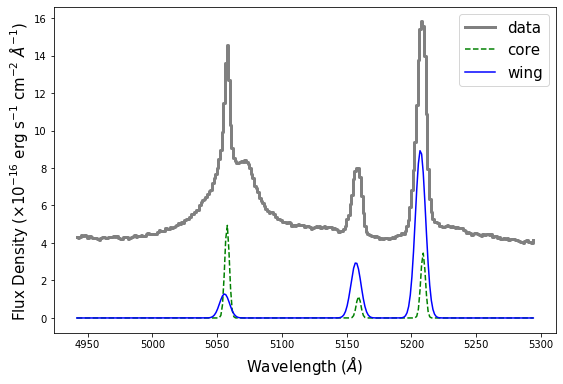

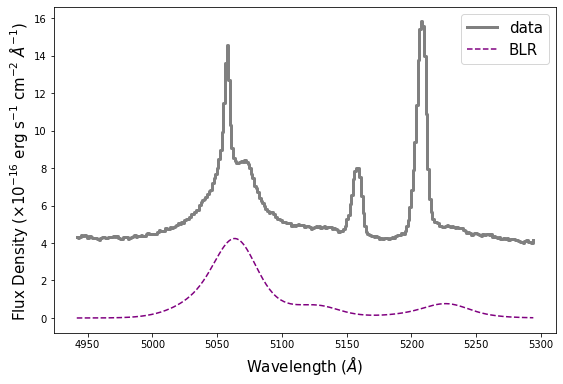

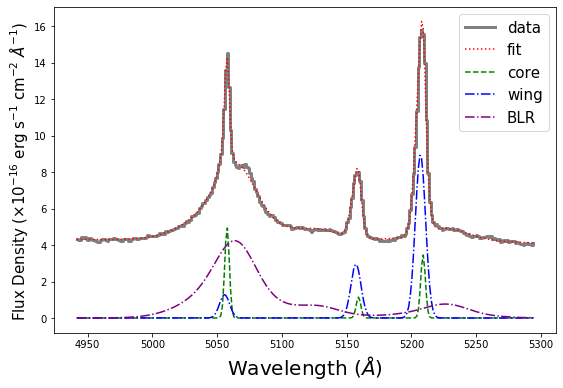

No handles with labels found to put in legend.


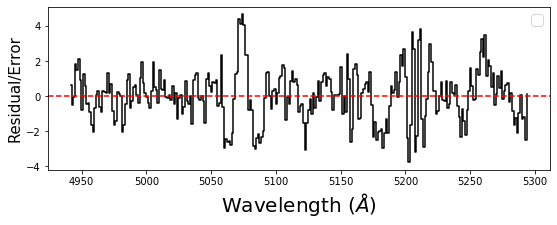

HE1107-0813
[ 4.32483399e-01  1.92126109e+00  1.75368173e+04  7.84678654e+01
  1.80552868e+00  1.03502021e+00  1.74523192e+04  5.58908961e+02
  6.84355571e+00  2.77689323e+00  1.74998738e+04  1.08438626e+03
  6.01225678e+00  1.35542165e-37  1.67288518e+04  2.15137156e+03
 -9.39420546e+00  7.08424853e+01  8.44980471e+01] [5.58357926e-01 4.28015341e-01 4.70765088e+01 1.76164998e+02
 2.75698005e+03 7.38824198e-01 1.24601901e+03 5.72609816e+02
 3.36387245e+03 8.18236840e-01 1.56430636e+02 1.66316468e+02
 2.03188234e+03 2.08809743e-53 1.28939651e+03 5.76543173e+02
 8.11040584e-01 4.18818233e+00 1.24636176e+03]


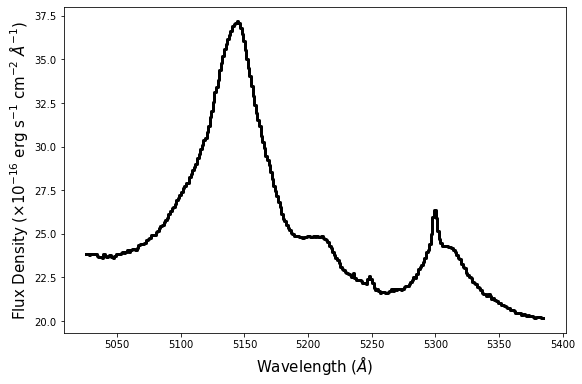

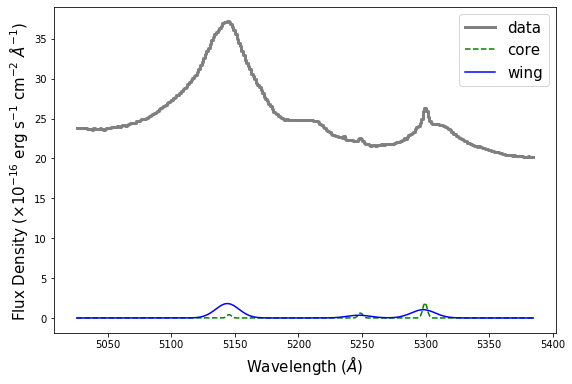

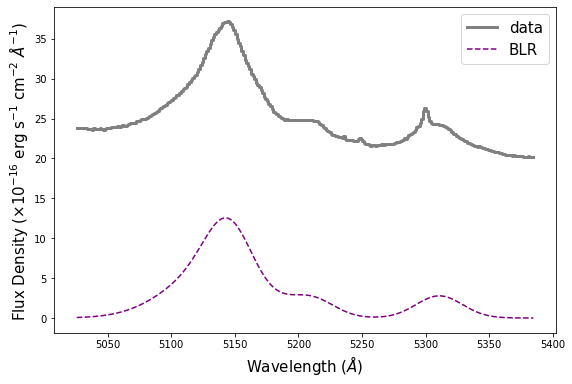

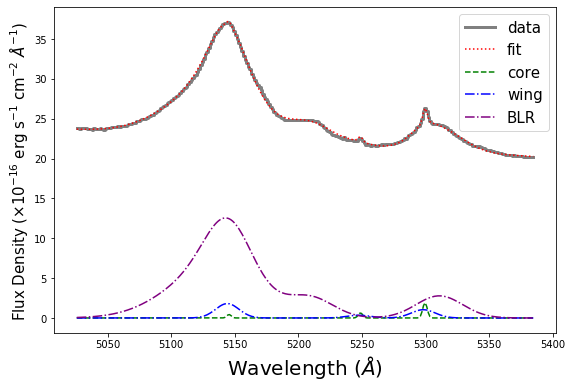

No handles with labels found to put in legend.


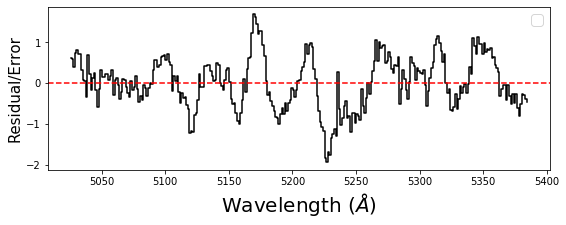

HE1108-2813
[ 9.19273762e+00  1.94617662e+01  7.16836369e+03  6.78784607e+01
  4.84054819e+00  1.09257184e+01  7.03644610e+03  2.41579489e+02
  8.39777205e+00  2.26330209e+00  7.34293432e+03  1.29194749e+03
  0.00000000e+00  0.00000000e+00  7.20000000e+03  1.00000000e+03
 -2.45838644e+00  2.33119262e+01  1.31917594e+02] [0.16362389 0.17651812 1.02641129 1.5589437  0.10855715 0.21331916
 2.46290563 2.87757738 0.04765061 0.02308448 5.00097747 5.81923591
 0.         0.         0.         0.         0.06436476 0.32367349
 2.40682981]


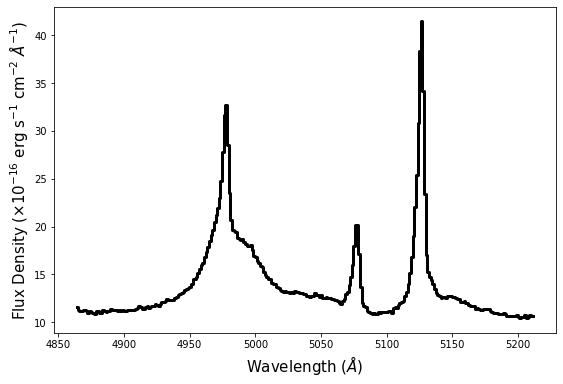

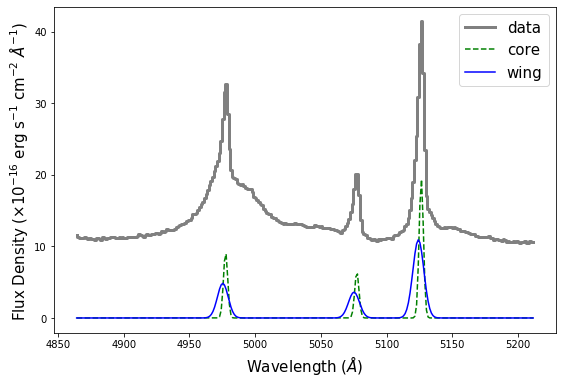

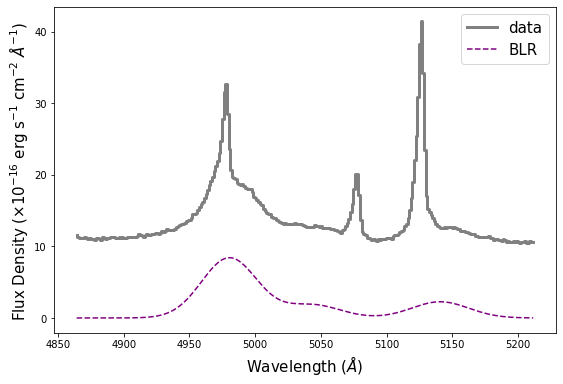

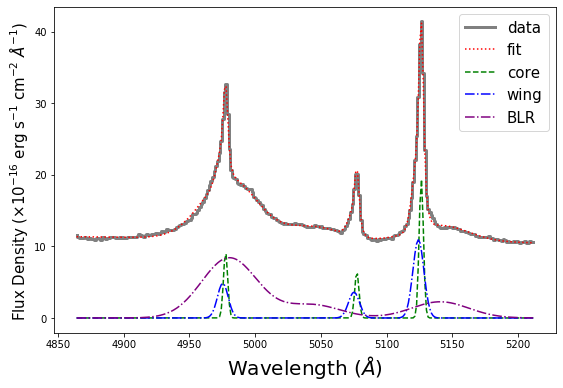

No handles with labels found to put in legend.


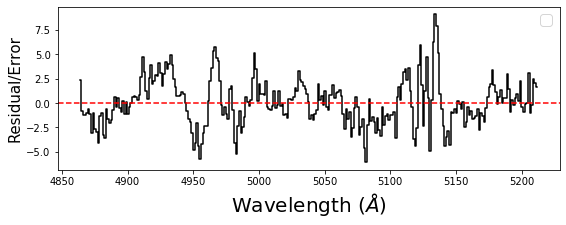

HE1126-0407
[ 1.71588924e+00  1.83944185e+01  1.80297014e+04  1.20209812e+02
  3.71679809e+00  4.01409664e+00  1.77454035e+04  3.54370150e+02
  1.34823847e+01  2.52506102e+00  1.80844128e+04  7.04078752e+02
  1.09867467e+01  1.10156616e+00  1.79702109e+04  1.72915055e+03
 -8.60066963e-01  1.85109433e+01  2.84297955e+02] [ 0.13571224  0.10312149  0.7530624   0.97462276  0.18189449  0.0737732
  7.16289245  5.07387921  0.13650678  0.04655113  3.97612793  7.86420252
  0.14786041  0.05768911  4.86549987 11.78696937  0.08542495  0.44876757
  6.96098392]


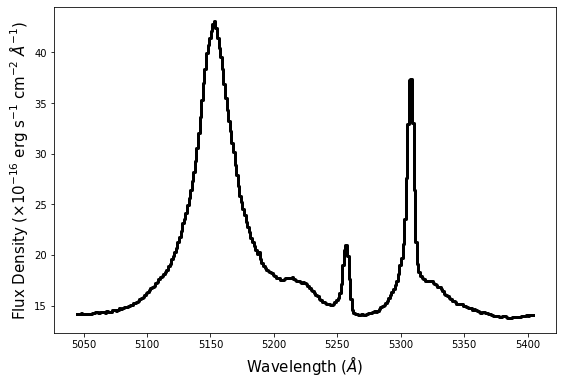

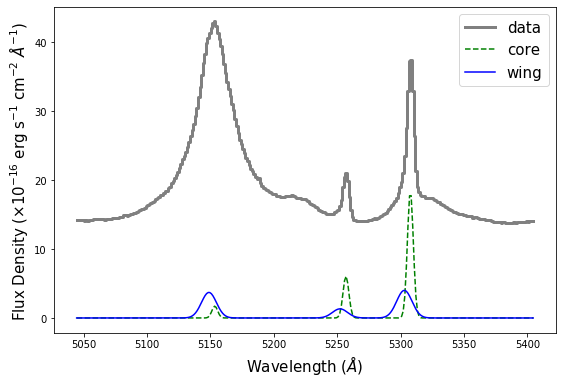

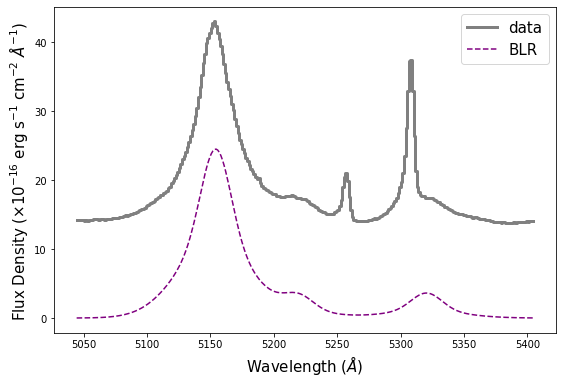

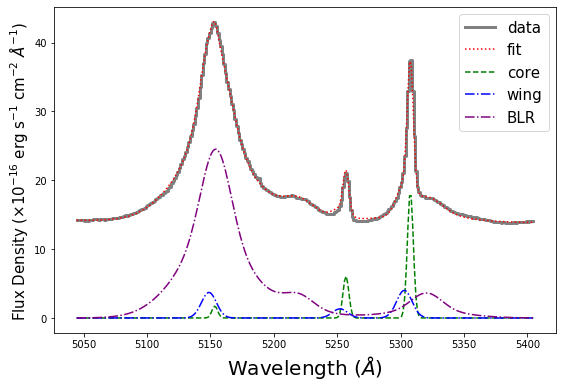

No handles with labels found to put in legend.


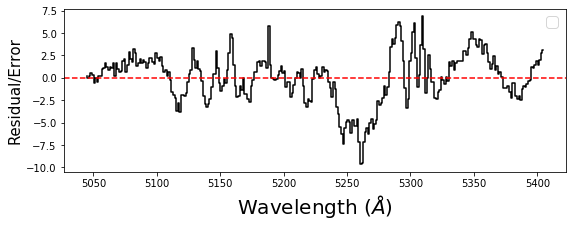

HE1237-0504
[ 5.03775362e+00  7.70214236e+01  2.48358744e+03  1.10466649e+02
  5.33396257e+00  1.27299658e+01  2.28733652e+03  3.14955755e+02
  1.54162061e+01  3.96254917e+00  2.47412652e+03  1.65048261e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.65868999e+00  1.29384615e+01  1.96250923e+02] [0.2125787  0.32820136 0.55287455 0.67407454 0.1482656  0.22685691
 3.35873023 2.63461307 0.04637563 0.02301004 3.51367495 4.02637068
 0.         0.         0.         0.         0.05386765 0.26663089
 3.21910315]


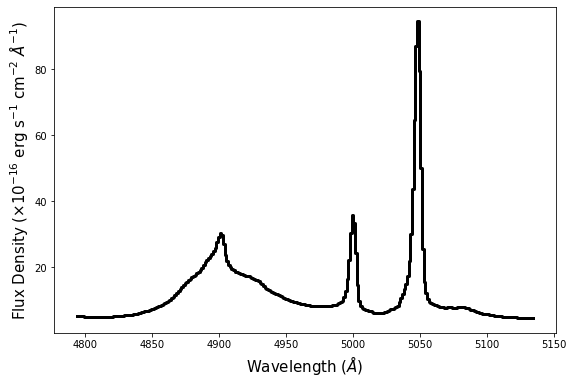

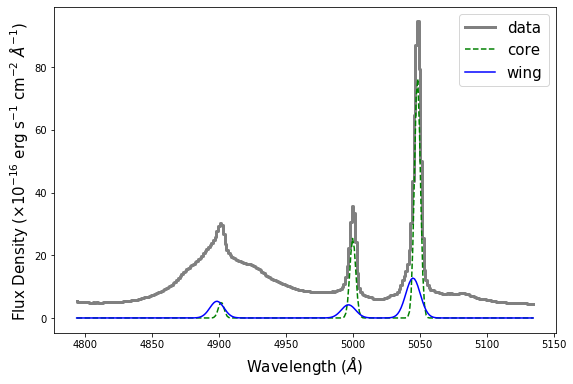

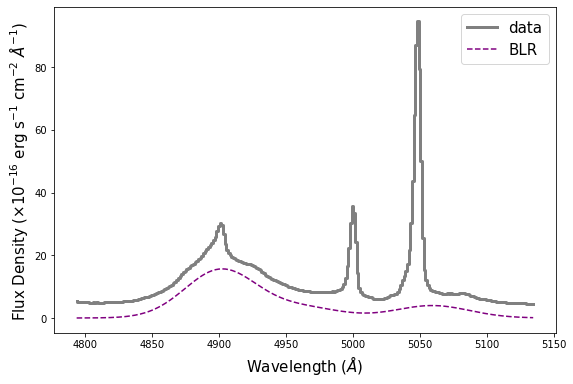

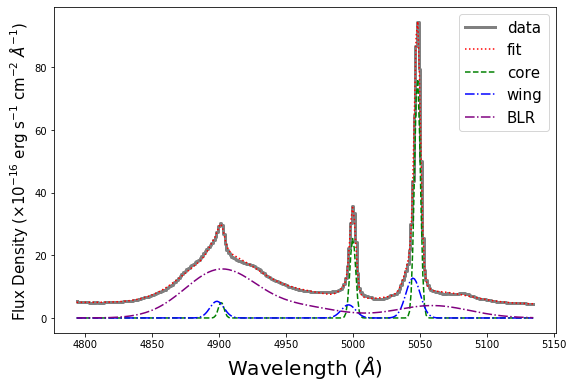

No handles with labels found to put in legend.


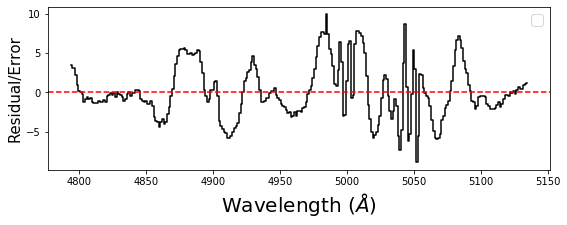

HE1248-1356
[ 5.18894579e-01  4.06539655e+00  4.26238559e+03  2.02351023e+02
  2.72063428e+00  2.55332884e+01  4.29016845e+03 -5.30454742e+01
  1.03932026e+00  2.48467009e-01  4.35570937e+03  1.30185621e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.15852683e-02  3.84442353e-01 -2.77828628e+01] [9.79735087e-02 3.25680343e-01 3.08132198e+00 7.65152419e+00
 1.27481945e-01 3.29934494e-01 5.75263509e-01 5.29392970e+01
 2.38042235e-02 1.44399328e-02 2.17661442e+01 2.81145390e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.19877547e-02 2.09262441e-01 3.34914442e+00]


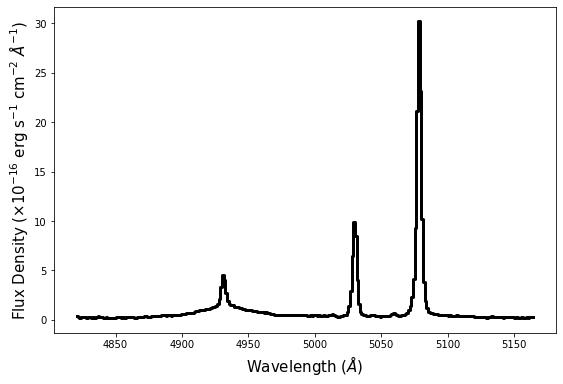

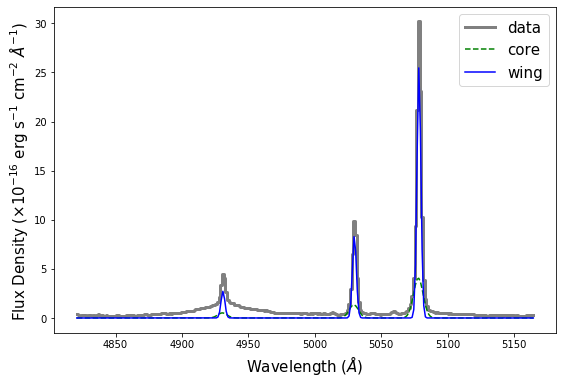

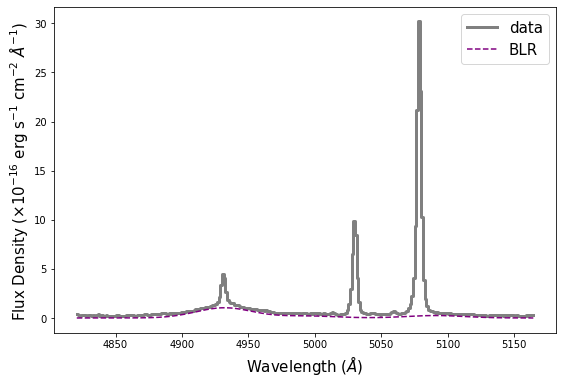

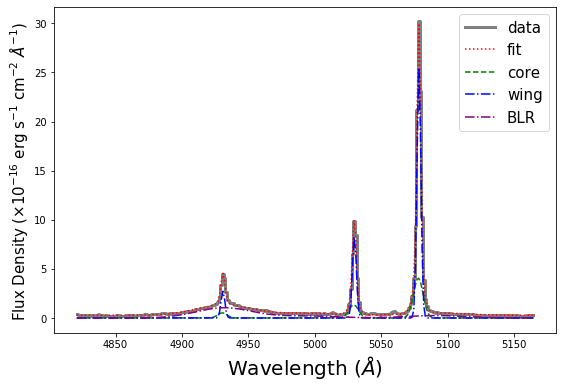

No handles with labels found to put in legend.


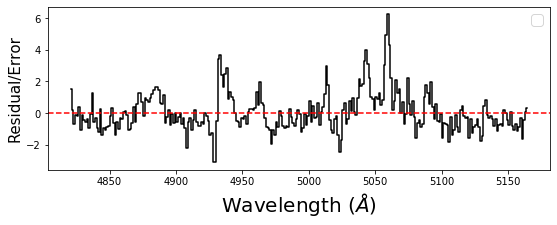

HE1330-1013
[ 9.33266240e-01  4.10296363e+00  6.73961398e+03  7.10225010e+01
  4.95780395e-01  1.25842328e+00  6.61096581e+03  2.22369302e+02
  8.62375214e-01  2.74725764e-01  6.99145364e+03  1.66150066e+03
  2.14746373e+00  3.00665145e-01  6.81550692e+03  6.22994119e+02
 -2.68111560e-01  2.83533840e+00  1.28648173e+02] [7.76229120e-02 1.08519809e-01 1.80207783e+00 3.69913242e+00
 8.01591092e-02 1.07327151e-01 1.28312725e+01 7.66060597e+00
 4.32915501e-02 1.85293420e-02 2.65495600e+01 4.84130509e+01
 5.05846438e-02 1.91625832e-02 1.14556802e+01 1.56589036e+01
 3.13783546e-02 1.57048323e-01 1.30905209e+01]


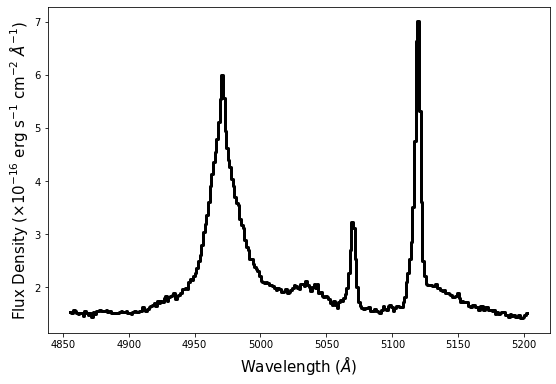

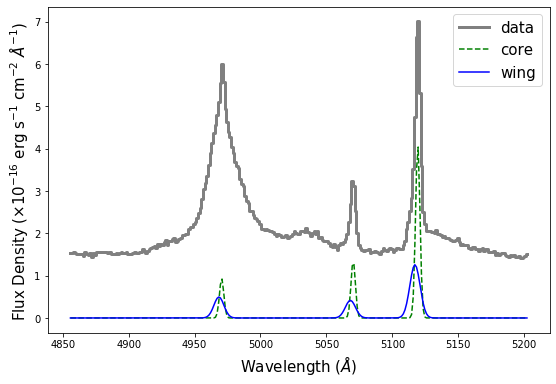

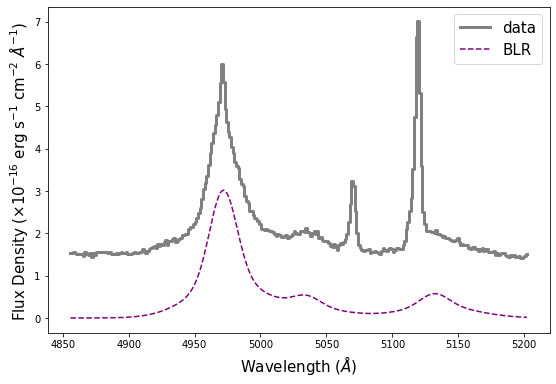

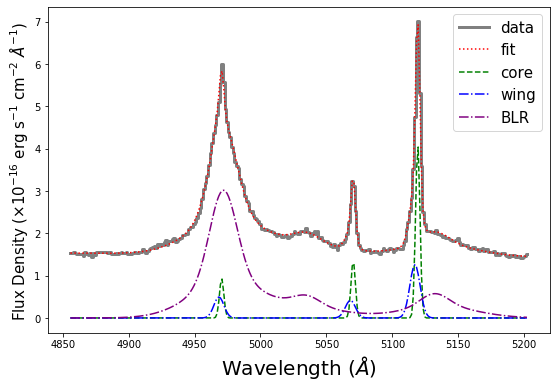

No handles with labels found to put in legend.


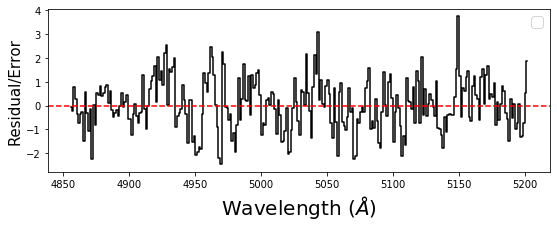

HE1353-1917
[ 5.24227096e-01  6.31076440e+00  1.04852688e+04  8.37467618e+01
  1.85740589e-01  7.66894111e-01  1.03046757e+04  4.62371055e+02
  6.23847703e-01  1.29300420e-01  8.21905711e+03  1.34314273e+03
  8.69043383e-01  6.44987423e-02  1.16810767e+04  2.27743374e+03
 -4.78553262e-01  5.94907715e+00  1.80593071e+02] [5.45640546e-02 7.24540904e-02 1.15257629e+00 2.17585161e+00
 5.19763594e-02 4.58477249e-02 2.43706317e+01 1.69873962e+01
 1.59031255e-01 2.09936133e-02 1.14143274e+02 1.71078558e+02
 5.46779855e-02 3.65156136e-02 3.96274454e+02 2.99771991e+02
 1.34476595e-01 6.82618211e-01 2.45646653e+01]


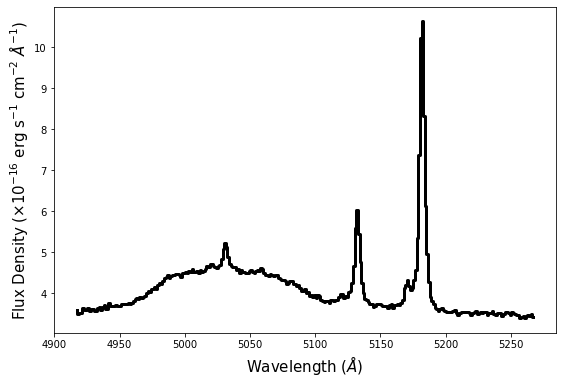

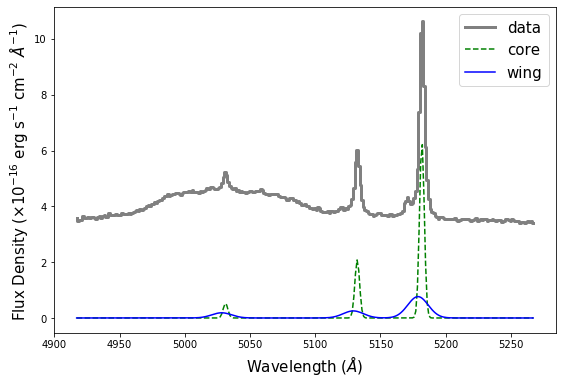

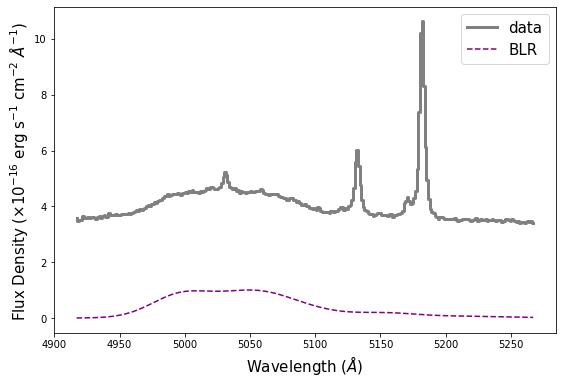

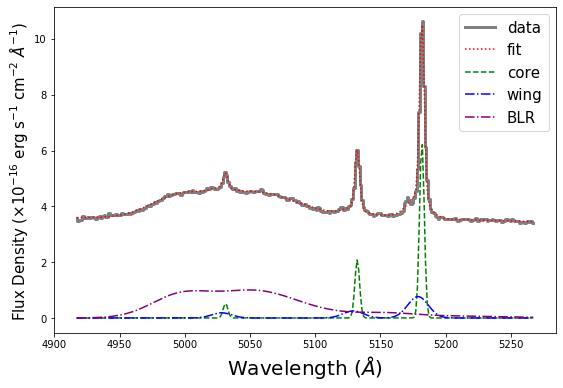

No handles with labels found to put in legend.


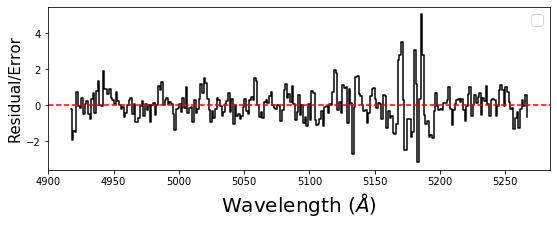

HE1417-0909
[ 1.57075375e+00  1.98754692e+01  1.30846633e+04  6.39883646e+01
  1.08257138e-01  3.77231385e+00  1.30423645e+04  1.79459604e+02
  2.21116079e+00  2.79055543e-01  1.32315020e+04  1.48761109e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -8.95970597e-01  6.34919917e+00  4.22987189e+01] [9.41219127e-02 2.58011818e-01 6.35318483e-01 1.41369152e+00
 7.61991936e-02 2.77730712e-01 3.05813574e+00 4.64431086e+00
 1.50211057e-02 7.60774582e-03 8.98895711e+00 1.13956795e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.74718237e-02 1.41535282e-01 3.14984101e+00]


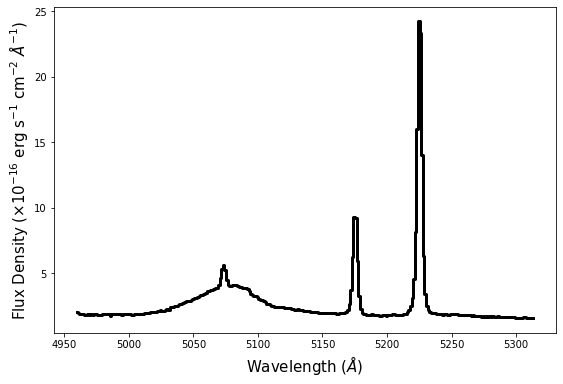

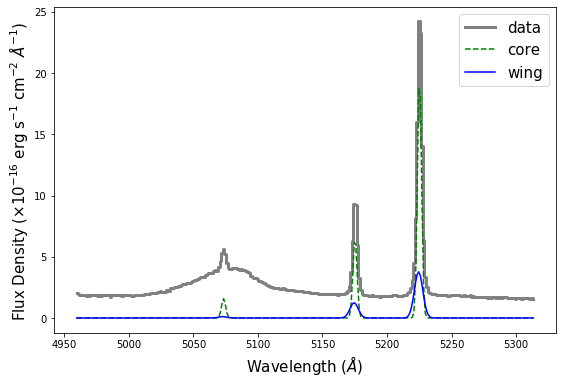

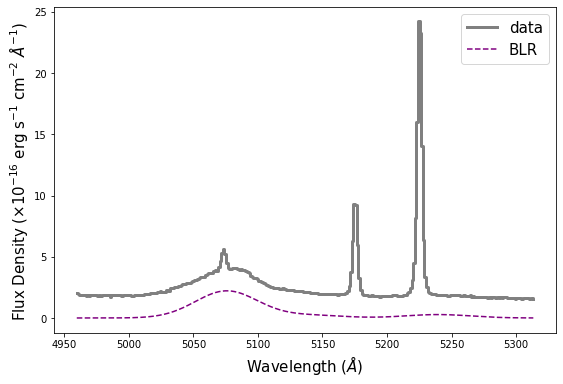

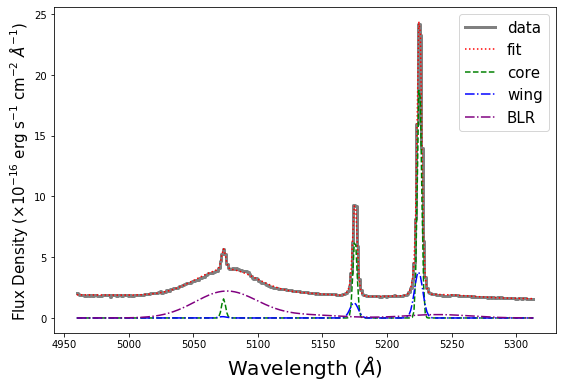

No handles with labels found to put in legend.


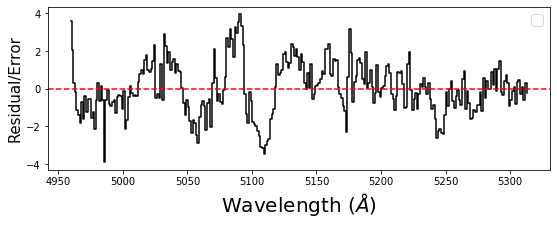

HE2128-0221
[ 7.23390244e-01  8.33013110e+00  1.57541212e+04  5.08949367e+01
  8.73406898e-01  2.61060682e+00  1.57198721e+04 -1.37238104e+02
  1.18350769e+00  1.63472850e-01  1.58144564e+04  9.08493795e+02
  0.00000000e+00  0.00000000e+00  1.57440000e+04  1.00000000e+03
 -2.61139992e-01  2.43458916e+00  3.42491415e+01] [7.60602615e-02 2.88792127e-01 1.07437608e+00 2.36206864e+00
 6.84861914e-02 3.08195804e-01 2.57412936e+00 5.63805160e+00
 1.21173996e-02 3.94317762e-03 5.88391973e+00 8.63745630e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.06735662e-02 5.50705663e-02 2.55784657e+00]


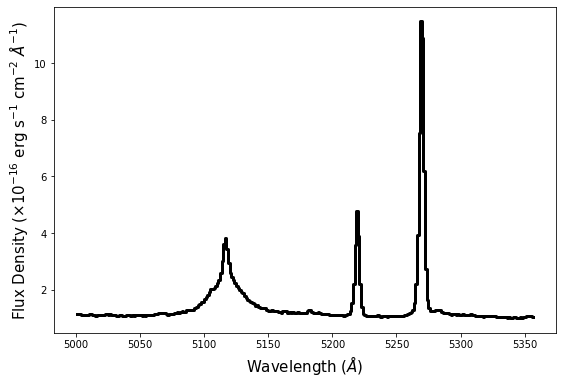

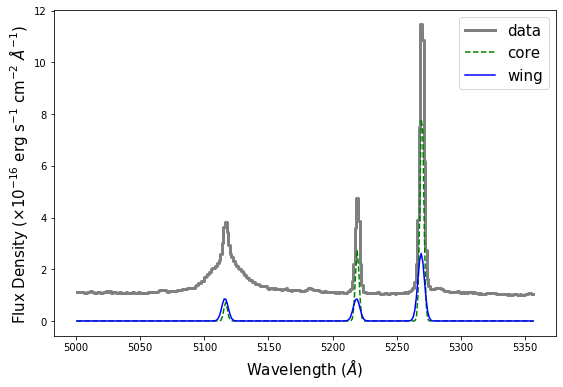

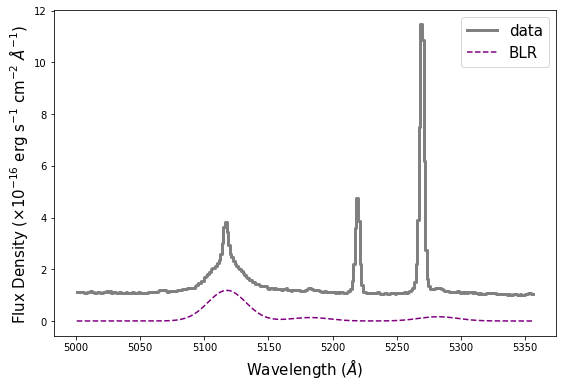

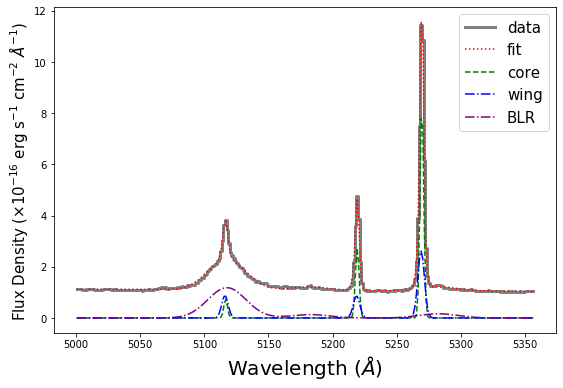

No handles with labels found to put in legend.


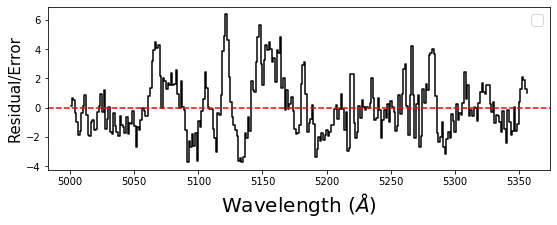

HE2211-3903
[2.70932865e+00 1.89987117e+01 1.18577173e+04 6.88517271e+01
 3.46903248e-01 1.53677939e+00 1.17429615e+04 2.20793172e+02
 2.42360718e+00 3.86759982e-01 1.16353502e+04 2.60255576e+03
 0.00000000e+00 0.00000000e+00 1.19140000e+04 1.00000000e+02
 1.00659898e+00 4.25735352e-01 1.14755750e+02] [1.24191405e-01 3.85579825e-01 2.20716069e+00 5.50169722e+01
 4.98618057e+02 6.95084995e+00 9.46914392e+02 1.15858154e+03
 4.98450457e+02 5.56238521e+00 4.82824090e+02 2.77321425e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.92786810e+00 2.44928645e+01 9.45373431e+02]


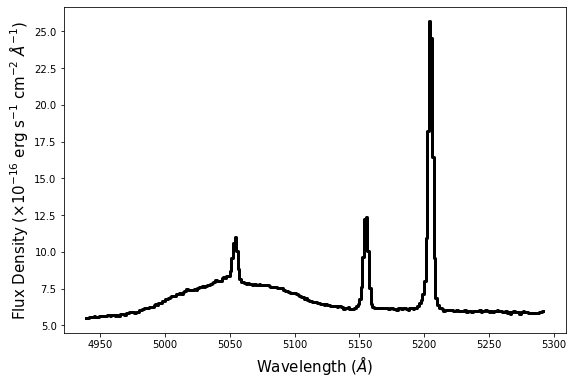

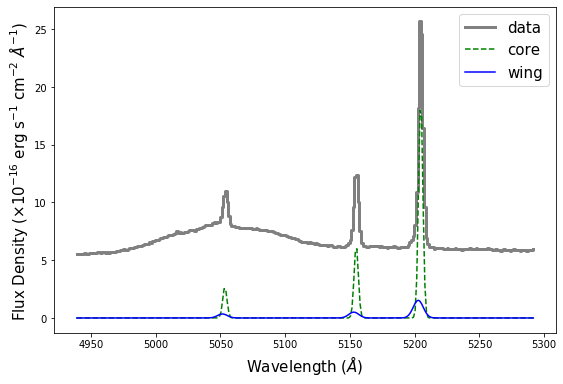

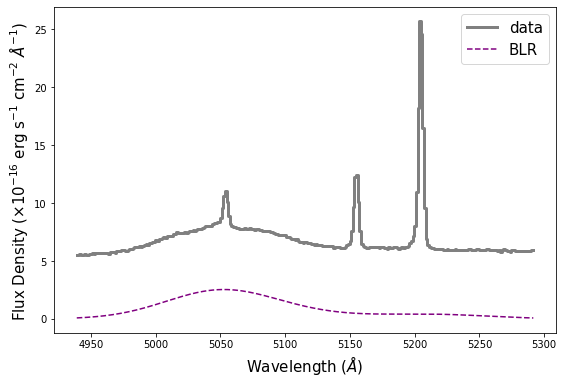

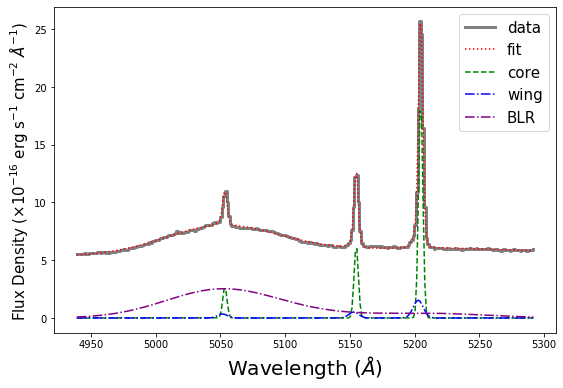

No handles with labels found to put in legend.


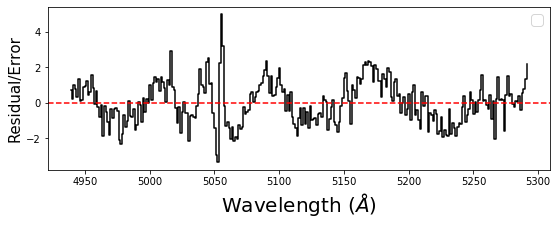

HE2222-0026
[ 5.88382358e-01  2.81510182e+00  1.74054468e+04  1.35526506e+02
 -1.40197469e-01  6.23222098e-01  1.71854050e+04  2.92518811e+02
  8.18316434e-01  1.06063085e-01  1.85464899e+04  6.05040843e+02
  1.36128528e+00  1.46428161e-01  1.75189187e+04  1.73755326e+03
 -1.91537857e-01  2.29647325e+00  2.20041875e+02] [3.05885238e-01 5.57618405e-01 4.38798004e+01 8.96365219e+01
 3.23057494e+02 6.08267653e-01 7.70731407e+02 7.08677810e+02
 3.23074016e+02 1.01455173e-01 4.46171446e+02 3.81532987e+02
 3.04393648e+03 2.58412471e+00 9.27072543e+03 1.08050121e+04
 3.67680605e+00 2.16640970e+01 7.71959889e+02]


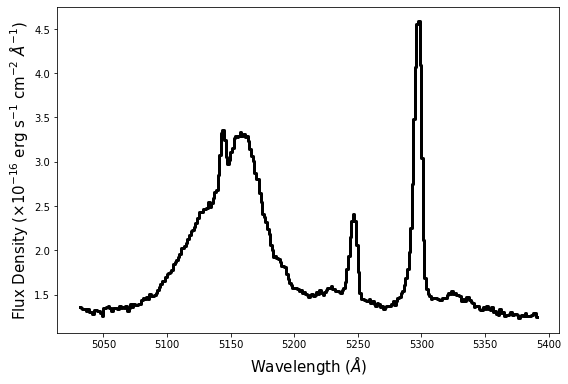

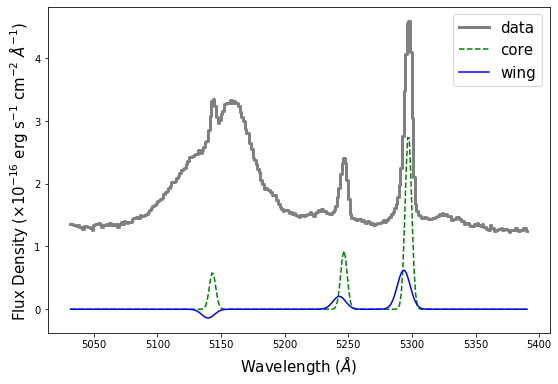

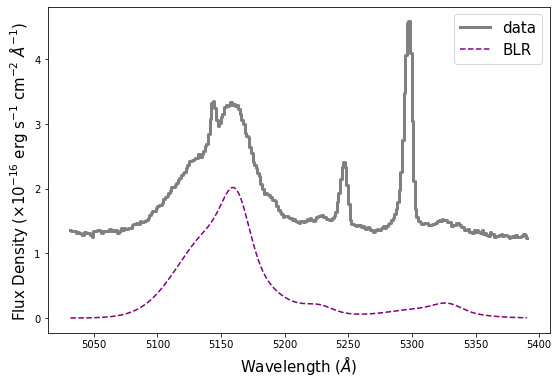

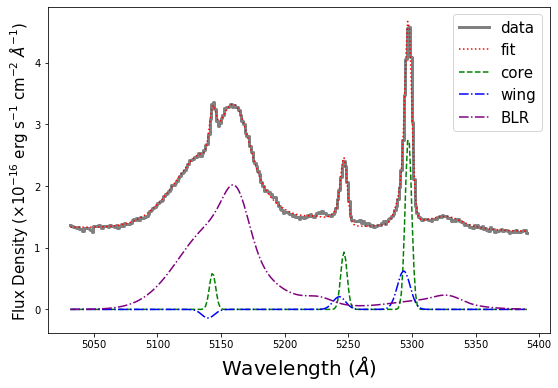

No handles with labels found to put in legend.


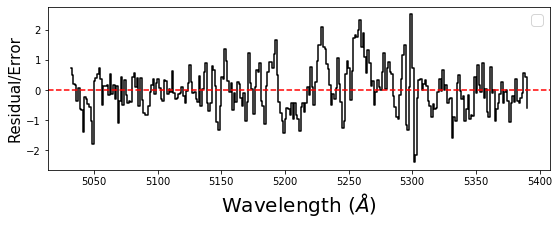

HE2233+0124
[ 1.49358208e-01  1.23903130e+00  1.69882055e+04  1.75460641e+02
  8.62493764e-02  1.91895202e-01  1.70327349e+04  5.65403416e+02
  3.08469463e-01  2.45307570e-19  1.88649511e+04  4.17276348e+03
  1.98377988e-01  1.17590646e-23  1.51806917e+04  1.27721841e+03
  1.08244893e-01 -2.54183385e-01 -4.45294574e+01] [3.54179999e-02 1.73966870e-01 8.16636136e+00 6.02115164e+01
 1.59324891e+02 2.03641001e+00 7.28232902e+02 4.36638361e+02
 8.89602717e+00 4.81482486e-35 5.07507730e+03 4.78600013e+03
 1.59564518e+02 2.93873588e-39 9.81958786e+02 1.19481185e+03
 2.90413842e+00 1.35983251e+01 7.28358583e+02]


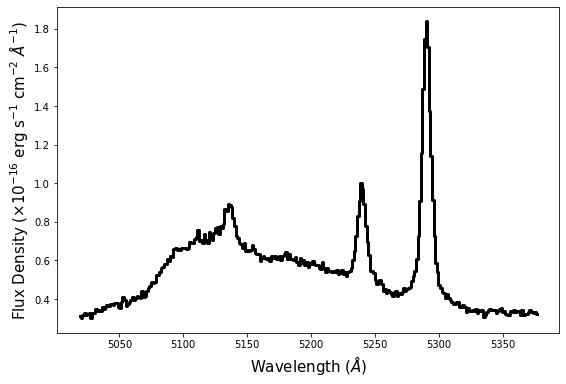

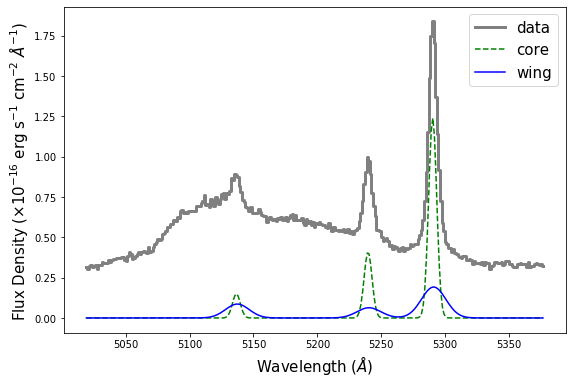

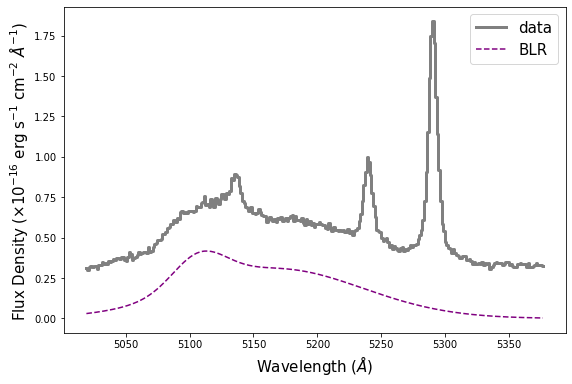

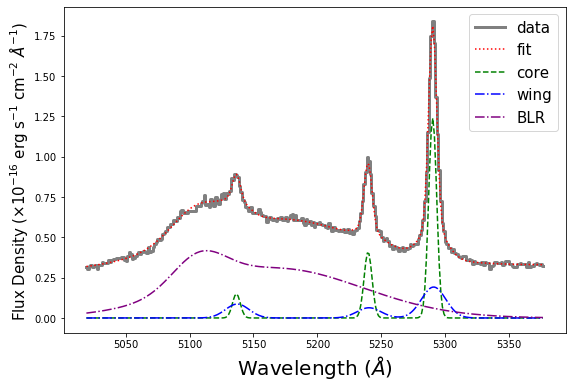

No handles with labels found to put in legend.


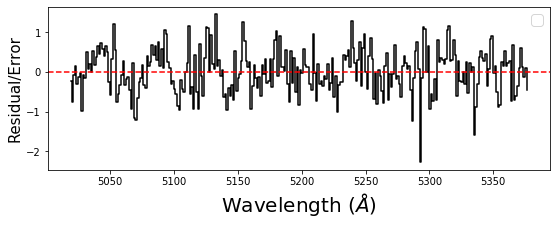

HE2302-0857
[ 6.64207324e+00  6.34207904e+01  1.41419806e+04  1.98471902e+02
  8.23109649e-02  9.24702658e+00  1.43952870e+04  5.33259201e+02
  5.85611877e+00  5.73696607e-01  1.52743001e+04  1.55125096e+03
  5.97546279e+00  1.67212515e+00  1.24366552e+04  1.90266704e+03
 -5.90601028e+00  4.26646238e+01 -2.53306370e+02] [5.15622228e-01 6.96806517e-01 2.52330903e+00 2.78888212e+00
 8.20280749e-01 6.42871803e-01 2.05367551e+01 2.58080135e+01
 1.32077773e+00 2.80876452e-01 3.26526495e+02 1.98119397e+02
 8.91845866e-01 2.43400720e-01 3.93405722e+02 1.80025643e+02
 4.54598864e-01 2.35734666e+00 2.04131680e+01]


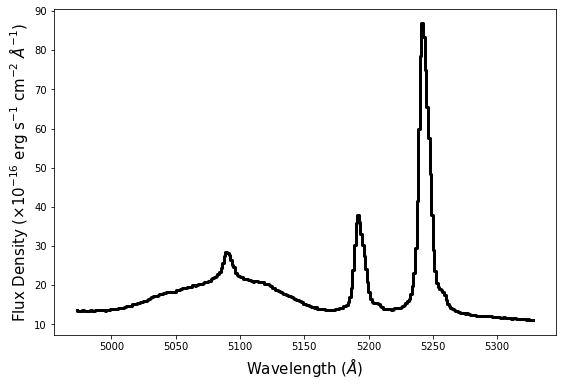

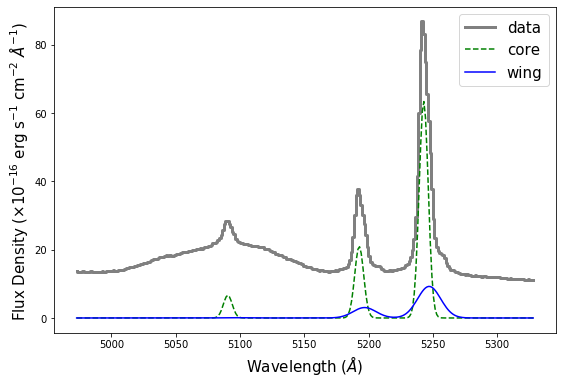

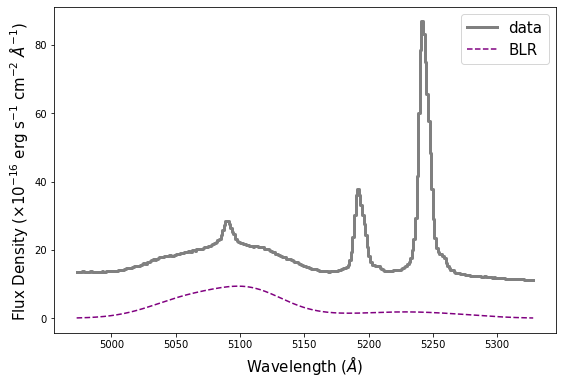

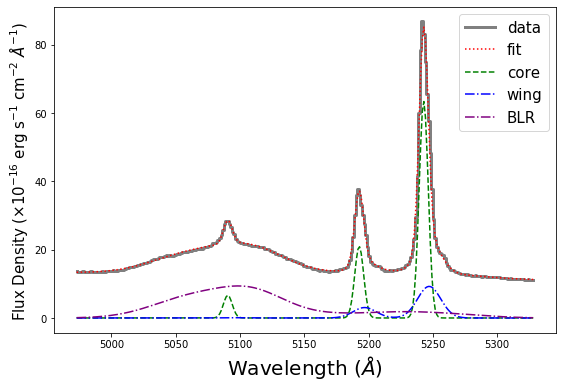

No handles with labels found to put in legend.


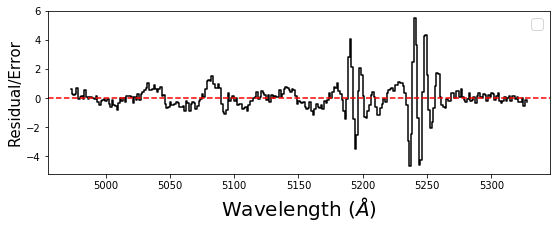

In [7]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

p_init= {'HE0021-1810':[1.2078087029112003, 17.216257397715754, 16109.438661669787, 109.4543344840526, 0.32003645569835454, 10.221691696984903, 16011.043287368566, 299.0443333993169, 1.212487635001326, 1.896327387771639, 10860.551642375163, 2396.7311867539993, 0.0, 0.0, 15959.0, 1000.0, 1.1613702741692253, 1.7761415668341576]
        ,'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,200.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[1.7,4.5,7160.0,40.0,0.12,2.5,7100.0,120.0,1.0,1.0,6960,1300.0,1.0,1.0,7190,430.0,-0.001,2.0]
        ,'HE0114-0015':[9.49004680758341, 9.396339789022234, 13674.43099983812, 124.77444289234994, -0.13132264613174283, 0.6277728114102422, 13667.099698829676, 390.65109512546394, 1.7833455112870613, 0.5353495302825251, 13699.168335667626, 1196.487856196145, 0.0, 0.0, 13680.0, 1000.0, -0.23908159151410913, 2.5907549102410443]
        ,'HE0119-0118':[1,12.5,16302,50.0,3,3,16102,100.0,2,2,16302,1000.0,1,1,16302,2500.0,-0.001,0.1]
        ,'HE0212-0059':[0.1,1.0,7930,170.0,0.1,0.1,7630,450.0,1.0,1.0,7620,4000.0,0.1,0.1,4650,1090.0,-0.001,2.0]
        ,'HE0224-2834':[0.2,2.5,17940,50.0,0.3,0.3,17640,200.0,0.1,0.1,17940,1500.0,0,0,17940,1500.0,-0.001,0.1]
        ,'HE0227-0913':[3,6,4785,150,2,7,4385,300.0,7,1.8,4935,400.0,3,0.5,4735,1500.0,-0.3,4.7]
        ,'HE0232-0900':[2,40,12942,50.0,5,5,12742,100.0,5,1,12942,1000.0,0,0,12942,1000.0,-0.001,0.1]                                     
        ,'HE0253-1641':[2,10,9476,110.0,1,6,9176,370.0,1,1,9476,1500.0,0.5,0.5,9476,550.0,-0.001,0.5]
        ,'HE0345+0056':[0.5,20,9300,150,5,10,9000,300,9,1.8,9300,400,30,2.5,9300,1500,0.3,7.1]
        ,'HE0351+0240':[2.2,37,10600,77,1.1,1.5,10618,277,1.5,0.07,11580,320,3,0.35,10650,1344,-0.3,3]                                                    
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[0.9,8.5,12600,90,0.2,2.0,12500,220,1.7,0.07,12600,450,1.3,0.2,12600,1600,-0.5,4.0]
        ,'HE0433-1028':[13.498309495582456, 82.0036724538741, 10588.868384256855, 128.10886151673859, 8.456291212671625, 88.97986599729782, 10276.462509524117, 335.30436332023555, 41.2375142887152, 4.2339599172191456, 10497.132697547311, 921.657146942224, 21.28951494125379, 5.680434608820318, 11223.443685503507, 2035.0957234836976, -16.914746969820914, 117.31100961689863]
        ,'HE0853+0102':[0.1,0.9,15700,110.0,0.02,0.3,15670,320.0,0.1,0.1,15900,1640.0,0.0,0.0,17250,810.0,-0.001,0.1]
        ,'HE0934+0119':[8.286278726499965, 49.52415417049359, 15207.052731463187, 72.69407750471247, 4.136346630767625, 22.311137489056893, 15076.66602344673, 168.19078410905178, 21.320016384115423, 3.0418949753222244, 15203.482608797496, 572.0374649611216, 9.11358996524406, 0.5032636297782367, 15199.713290594773, 1485.8783971046369, -3.852104037486194, 33.88683447953653]
        ,'HE1011-0403':[5.679560250554006, 32.08184532672064, 17534.893712734636, 100.02782172331572, 2.7635613631553273, 16.628925824676713, 17313.593001568395, 256.7114554548123, 6.569155042965622, 0.3239135869786792, 17809.568357552558, 1831.8459636923594, 22.59495628469939, 3.0796703343687493, 17676.80483687451, 823.2528416149622, -0.03264532738966647, 21.095443410763075]
        ,'HE1017-0305':[0.1,1.5,14695,50,0.08,0.4,14595,200,0.7,0.09,14695,2000,0,0,0,0,-0.3,2.0]
        ,'HE1029-1831':[27.454854323789995, 8.289432728444677, 12121.291545072665, 72.18635426939773, 6.585131899061019, 39.883757930100906, 11987.388524295884, 217.16035718745735, 6.062687713586677, 1.9967767300402448, 11965.0962260633, 1623.130402912297, 8.331781018778745, 0.8584218047130702, 12591.074288497652, 859.3010709366221, -3.6820577540187283, 29.468309000290095]
        ,'HE1107-0813':[8.80671090e-02, 2.75608437e-01, 1.75401927e+04,7.75913242e+01,2.22481687e-01,1.41094267e-01, 1.75077822e+04, 5.35051805e+02,1.14165275e+00,4.09556843e-01,1.74632483e+04,1.10525072e+03,7.62270432e-01,1.35542165e-37,1.65777591e+04,2.24393199e+03,-1.20175359e+00,9.32108315e+00]
        ,'HE1108-2813':[27.105428799606074, 45.11123832645942, 7169.083504955203, 67.85810214903162, 11.637683835601413, 26.897964592164065, 7051.6747900086675, 236.92504342284278, 16.460639820722413, 4.64152642195189, 7353.615399701936, 1302.6679794875997, 0.0, 0.0, 7200.0, 1000.0, -6.327929811295385, 52.478521898623946]
        ,'HE1126-0407':[1,13,18200,100,2.5,3,18000,300,10,1.3,18200,800,7,1.8,18200,1600,-0.9,15]
        ,'HE1237-0504':[7.57277688e-01,1.15870359e+01,2.48324557e+03,1.12077574e+02,7.88740880e-01,2.07313537e+00,2.29207431e+03,3.13140698e+02,2.49266465e+00,6.36719444e-01,2.47395074e+03,1.64525110e+03, 0, 0, 0, 0,-2.46623417e-01,1.97946062e+00]
        ,'HE1248-1356':[0.1,1.5,4395.0,50.0,1.0,3.0,4195.0,100.0,1.0,1.0,4395,1000.0,0,0,0,0.0,-0.001,2.0]
        ,'HE1330-1013':[3.8218921486267234, 16.189644296556395, 6751.492525381073, 72.72502823229266, 2.1768719448573015, 4.019371418712531, 6610.988554001032, 223.72886433227637, 2.8979687275656847, 1.2687829684053438, 7006.152513832253, 2060.1450409322183, 6.972239192980408, 0.8650183824154536, 6833.816055304659, 673.1740308979133, -3.715326609840787, 24.172854416696296]
        ,'HE1353-1917':[5.236483609050953, 46.45256642216187, 10498.054886325122, 92.87394356771547, 1.0852776957030066, 6.600018061791628, 10303.333663655543, 370.2240269467084, 2.768460085151171, 0.6777145235661884, 8417.494541806254, 1482.6017995516875, 2.684236617141625, 0.18571713021213193, 11786.689880334721, 2054.632082909921, -3.2049989381443917, 29.092611258101567]
        ,'HE1417-0909':[2.01102112e-01,2.73183924e+00,1.30863622e+04,6.63479083e+01,5.88831173e-02,5.77557042e-01,1.30426451e+04,1.70403875e+02,2.80907956e-01,4.44174720e-02,1.31420336e+04,1.56750715e+03,0,0,0,0,-1.08503791e-01,7.98135144e-01]
        ,'HE2128-0221':[4.2967555930284735, 38.425863788474466, 15756.518753401653, 50.315486306443354, 3.9668680402794236, 11.556876773709128, 15724.475593555811, -140.61480520389588, 5.25913069324259, 0.6418794238600051, 15833.959791548157, 885.7131927955724, 0.0, 0.0, 15744.0, 1000.0, -0.4079330111033193, 6.01099918167622]
        ,'HE2211-3903':[0.6,2.4,11914,50.0,0.1,0.1,11714,100.0,0.1,0.1,11914,200.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[0.08,0.4,17400.0,140.0,0.04,0.05,17150.0,300.0,0.4,0.1,18500,650.0,0.02,0.01,17460,1750.0,-0.001,0.002]
        ,'HE2233+0124':[1.43357628e-02,1.49619255e-01,1.69916071e+04,1.63647639e+02,1.37932578e-02,3.41863482e-02,1.70008555e+04,4.26241737e+02,4.28182755e-02,2.45307570e-19,1.89446000e+04,4.53242530e+03,2.61072059e-02,1.17590646e-23,1.51936027e+04,1.29226675e+03,2.04530838e-02,-6.58462253e-02]
        ,'HE2302-0857':[30.08125075371935, 263.4915852081613, 14102.405012933865, 174.78361692454274, 5.234420820727908, 50.4264020928591, 14272.099786366725, 443.97703620906793, 12.465653653818647, 0.580439422201921, 15513.985182493981, 1399.4338046978553, 21.789736064188695, 7.5818140724399505, 12827.562641126544, 2106.3011612081536, -10.076688456785302, 88.0473440529682]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE1237-0504
[ 7.61869522e-01  1.16563446e+01  2.48224672e+03  1.13364823e+02
  7.91302566e-01  1.97917197e+00  2.28374235e+03  3.18949785e+02
  2.48713208e+00  6.34413913e-01  2.47609463e+03  1.64784583e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.47985411e-01  1.98582252e+00  1.98504369e+02] [3.84713748e-02 4.78186969e-02 5.90325783e-01 7.86990074e-01
 2.61337322e-02 3.88006769e-02 3.87528146e+00 2.39881653e+00
 7.99063276e-03 3.27709511e-03 3.40623161e+00 4.04365215e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.82433037e-03 4.35608104e-02 3.72267825e+00]


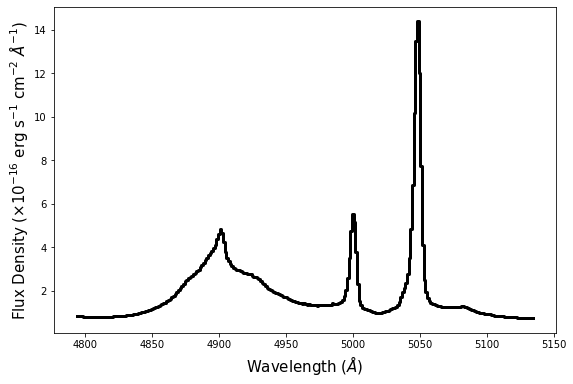

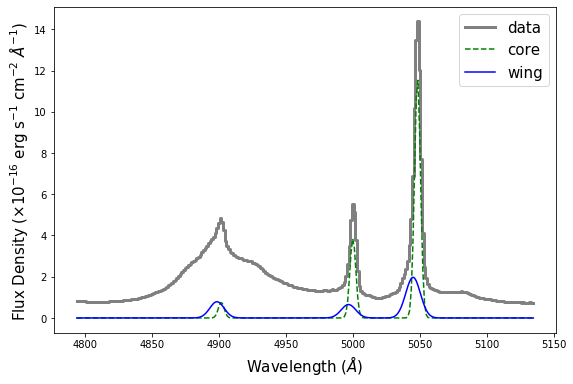

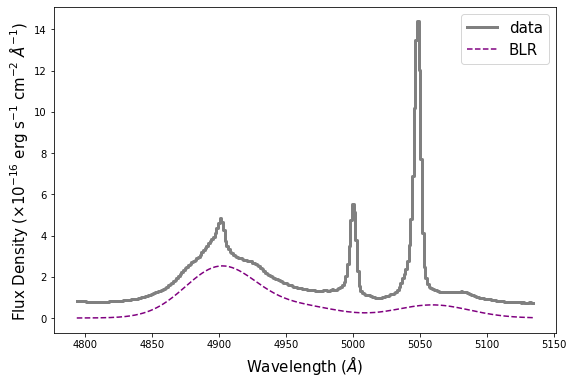

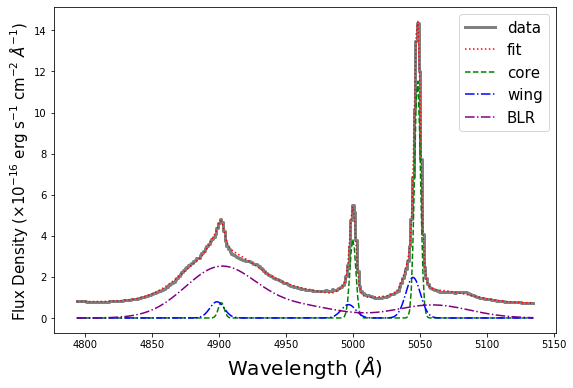

No handles with labels found to put in legend.


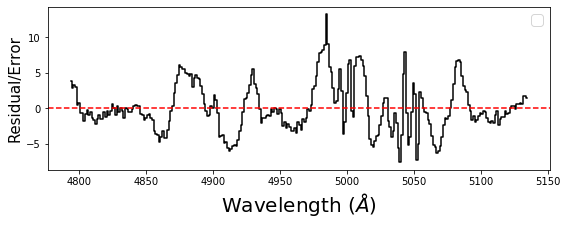

In [7]:
z = {"HE1237-0504":0.009}

objs = z.keys()

broad2= {'HE1237-0504':False}

p_init= {'HE1237-0504':[7.57277688e-01,1.15870359e+01,2.48324557e+03,1.12077574e+02,7.88740880e-01,2.07313537e+00,2.29207431e+03,3.13140698e+02,2.49266465e+00,6.36719444e-01,2.47395074e+03,1.64525110e+03, 0, 0, 0, 0,-2.46623417e-01,1.97946062e+00]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 
        

HE0114-0015


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 1.92162980e+00  3.11879221e+00  1.36698635e+04  1.16946453e+02
  1.06298556e-01  2.94428256e-01  1.36242869e+04  3.60719229e+02
  7.16256018e-01  2.26490294e-01  1.36932304e+04  1.19847030e+03
  0.00000000e+00  0.00000000e+00  1.36800000e+04  1.00000000e+03
 -1.59083096e-01  1.43701998e+00  4.55766159e+01] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


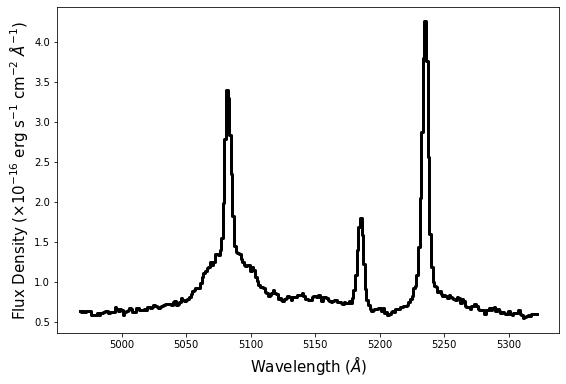

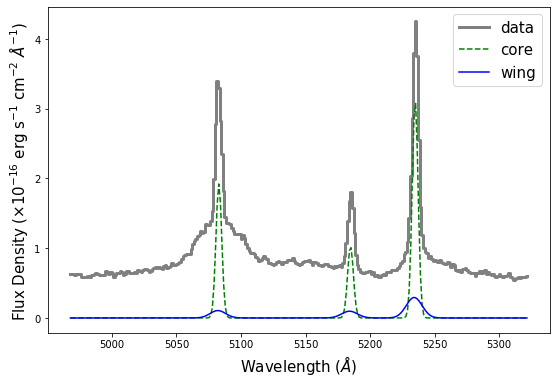

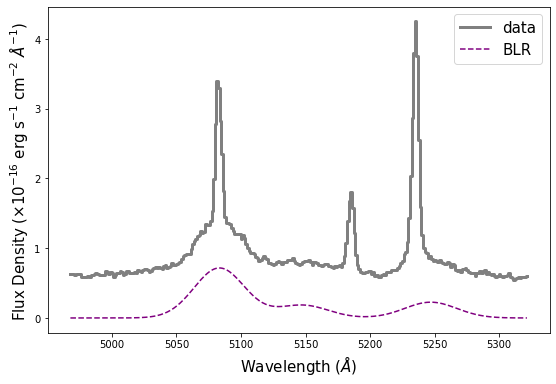

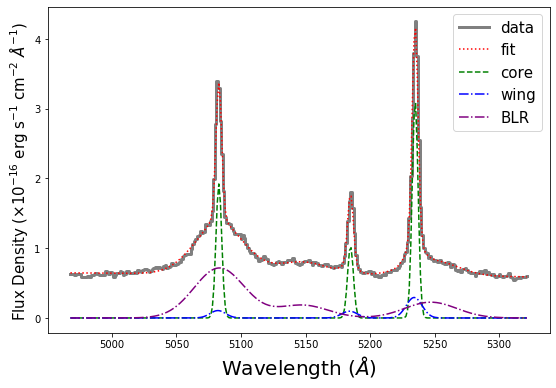

No handles with labels found to put in legend.


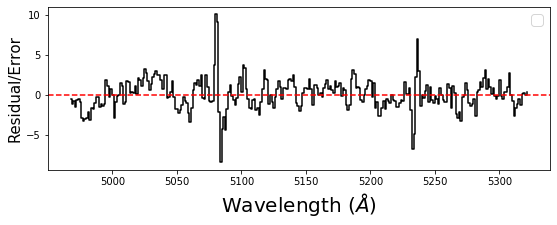

HE0433-1028


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 5.12559727e+00  3.41059622e+01  1.05786844e+04  1.30179284e+02
  4.14738853e+00  3.89766334e+01  1.02705890e+04  3.35147521e+02
  1.91623719e+01  1.99802829e+00  1.05090076e+04  9.51521182e+02
  8.95090399e+00  2.60112259e+00  1.13312062e+04  2.16086384e+03
 -7.20647244e+00  5.06877329e+01  3.08095406e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


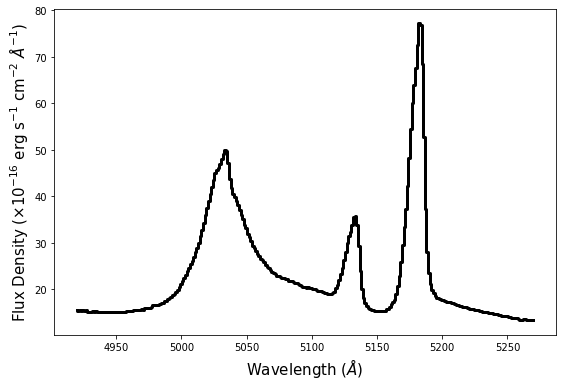

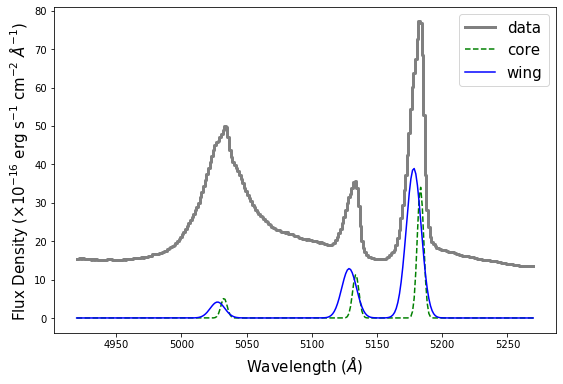

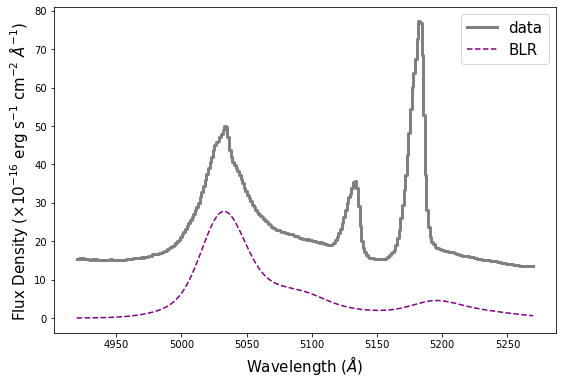

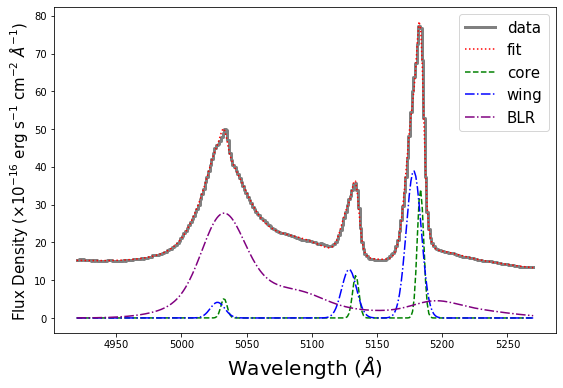

No handles with labels found to put in legend.


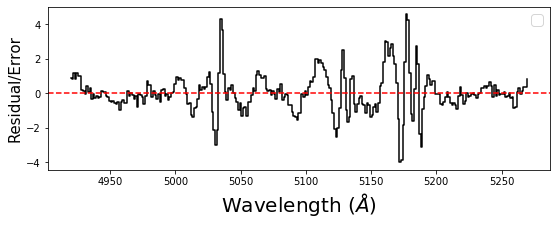

HE0934+0119


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 1.84152038e+00  1.28348675e+01  1.52070791e+04  6.82978777e+01
  1.14466381e+00  6.37155990e+00  1.50763417e+04  1.66368651e+02
  5.91106325e+00  7.26643183e-01  1.52086476e+04  5.75572482e+02
  2.62472421e+00  3.89402988e-01  1.51846519e+04  1.43252041e+03
 -1.38967414e+00  1.09623394e+01  1.30737408e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


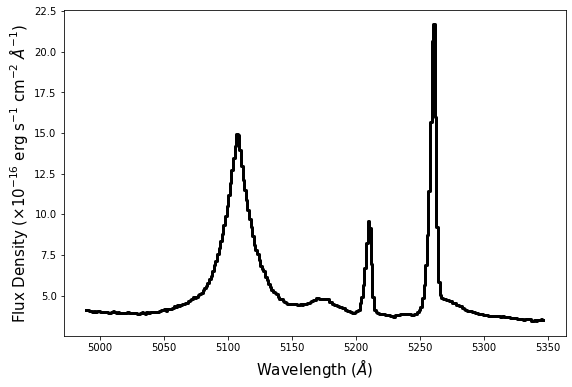

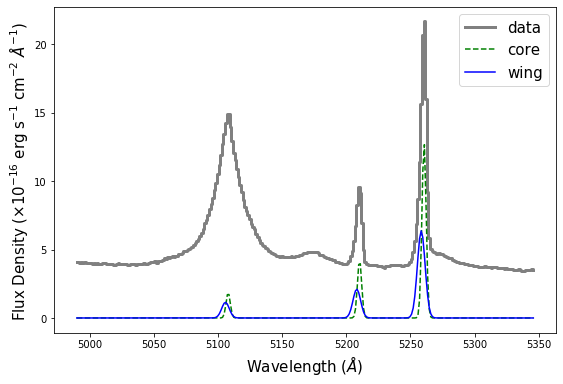

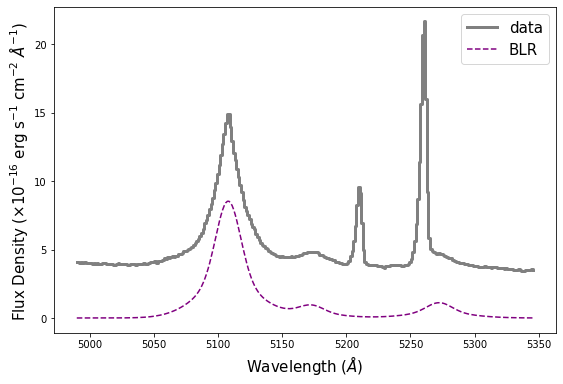

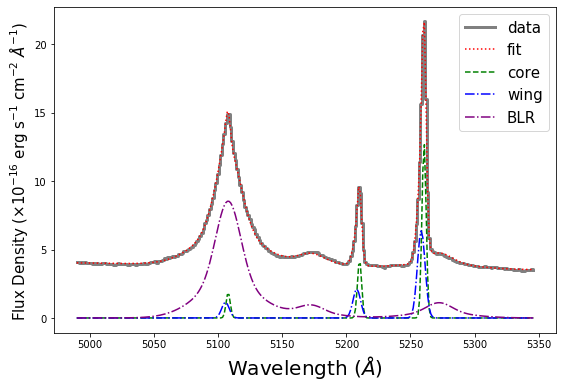

No handles with labels found to put in legend.


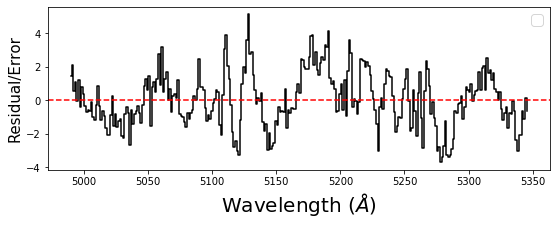

HE1011-0403


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 1.18619777e+00  7.65646262e+00  1.75317091e+04  1.00877178e+02
  7.32543034e-01  4.26993079e+00  1.73192079e+04  2.57932577e+02
  2.16485744e+00  3.74908191e-01  1.77025336e+04  1.50787379e+03
  5.21157705e+00  5.70857229e-01  1.76826294e+04  7.98747284e+02
 -1.35771471e+00  1.26147342e+01  2.12501192e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


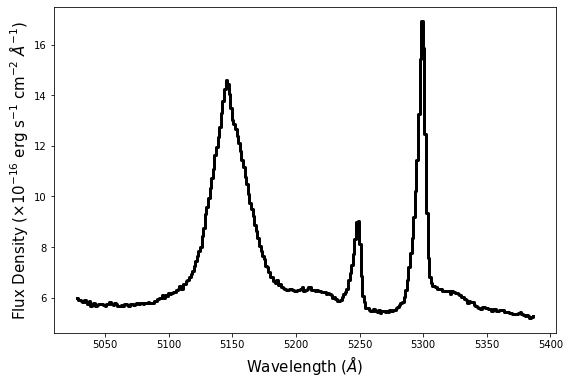

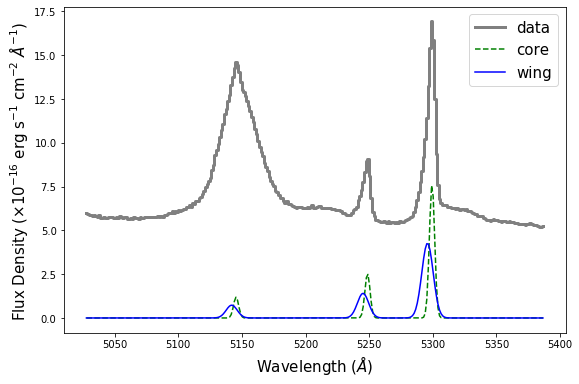

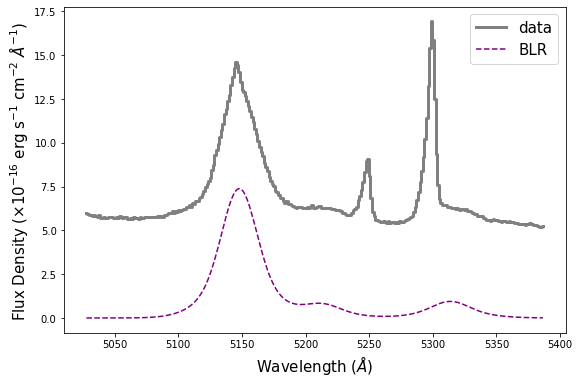

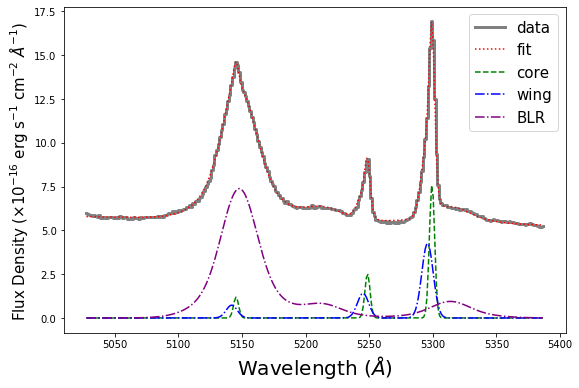

No handles with labels found to put in legend.


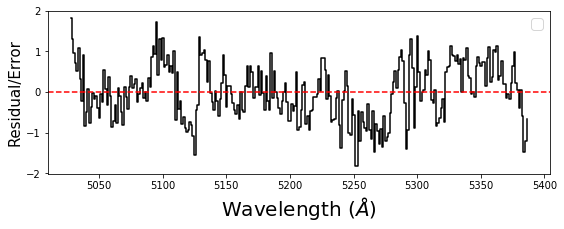

HE1029-1831


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 4.97567153e+00  3.46653876e+00  1.21134528e+04  8.21000298e+01
  1.28270528e+00  8.96443556e+00  1.19934868e+04  2.25032669e+02
  1.78865966e+00  3.70715936e-01  1.21068083e+04  1.67879820e+03
  2.46537709e+00  4.03432227e-01  1.25357172e+04  8.86559723e+02
 -5.58075599e-01  7.06782185e+00  1.19965993e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


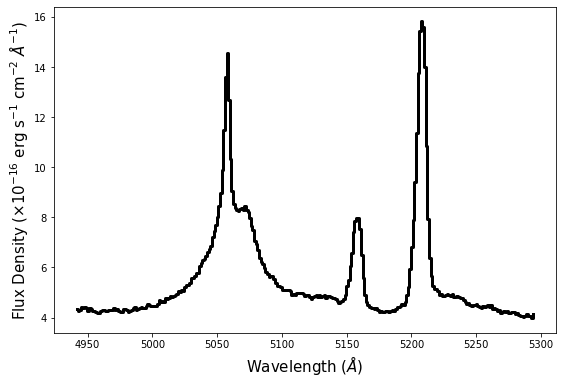

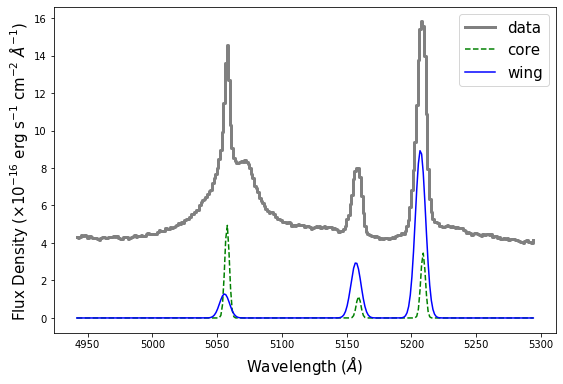

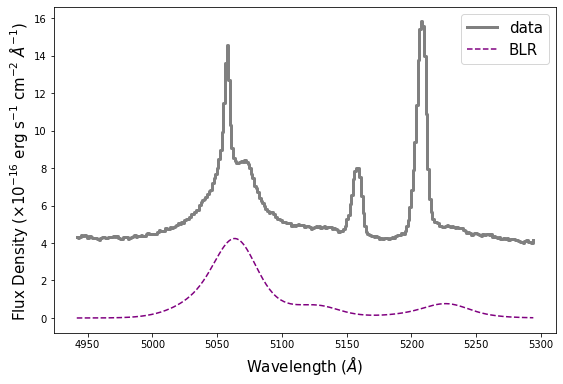

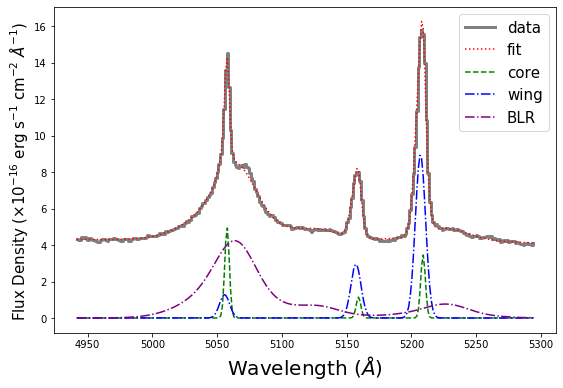

No handles with labels found to put in legend.


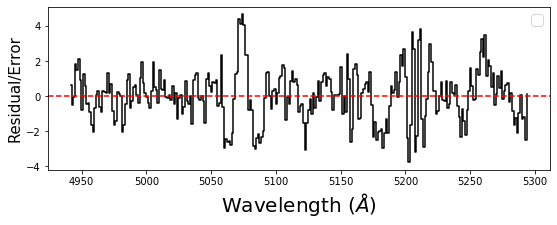

HE1108-2813


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 9.19273762e+00  1.94617662e+01  7.16836369e+03  6.78784607e+01
  4.84054819e+00  1.09257184e+01  7.03644610e+03  2.41579489e+02
  8.39777205e+00  2.26330209e+00  7.34293432e+03  1.29194749e+03
  0.00000000e+00  0.00000000e+00  7.20000000e+03  1.00000000e+03
 -2.45838644e+00  2.33119262e+01  1.31917594e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


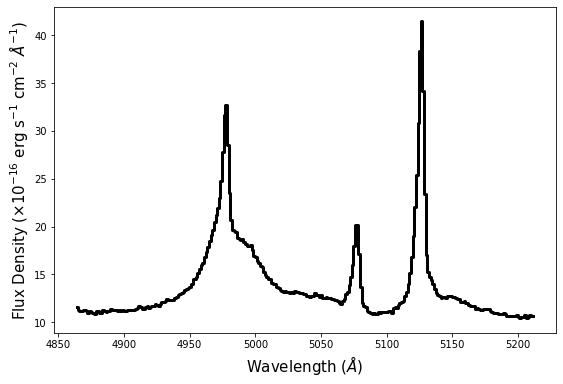

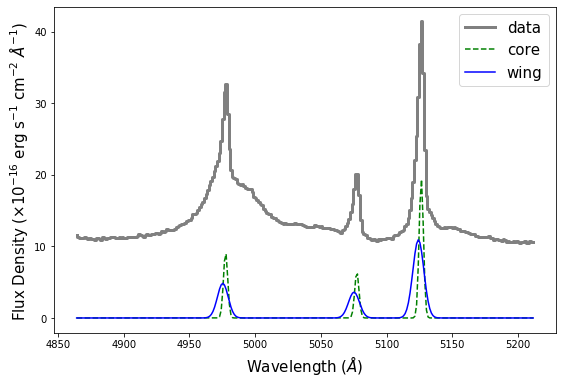

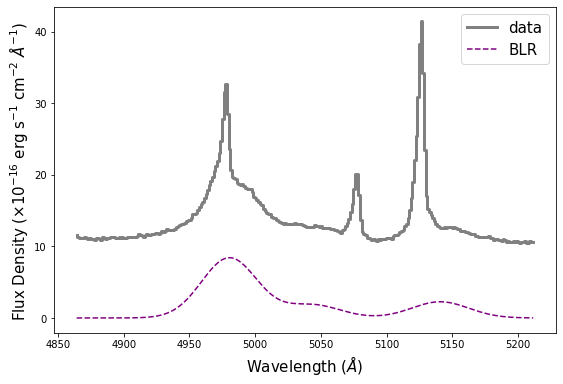

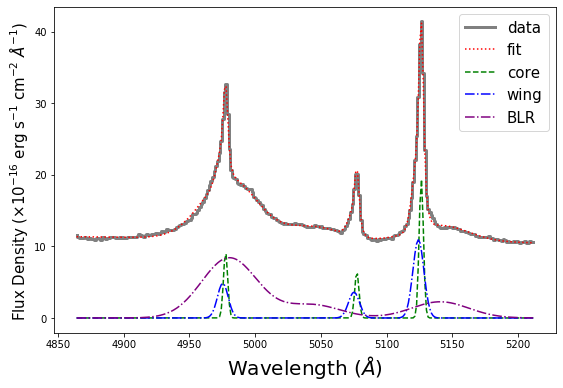

No handles with labels found to put in legend.


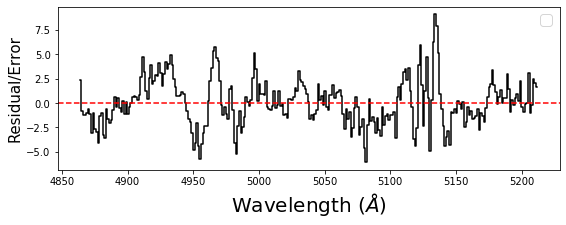

HE1330-1013


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 9.33266240e-01  4.10296363e+00  6.73961398e+03  7.10225010e+01
  4.95780395e-01  1.25842328e+00  6.61096581e+03  2.22369302e+02
  8.62375214e-01  2.74725764e-01  6.99145364e+03  1.66150066e+03
  2.14746373e+00  3.00665145e-01  6.81550692e+03  6.22994119e+02
 -2.68111560e-01  2.83533840e+00  1.28648173e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


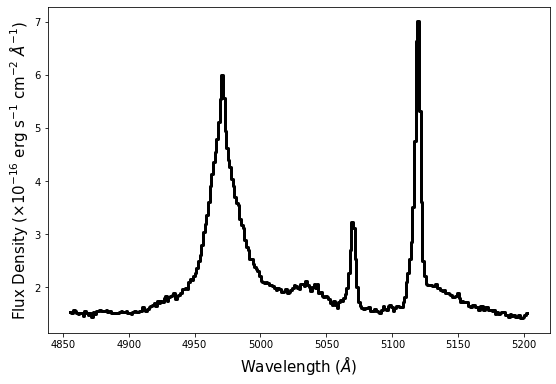

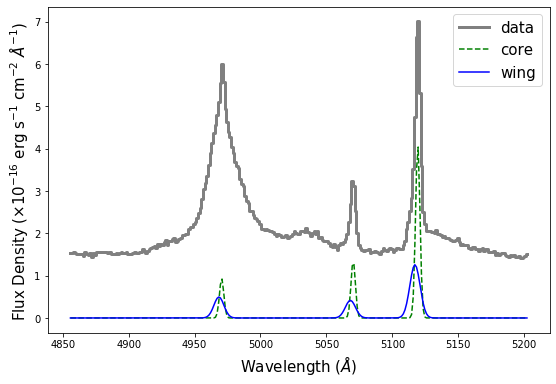

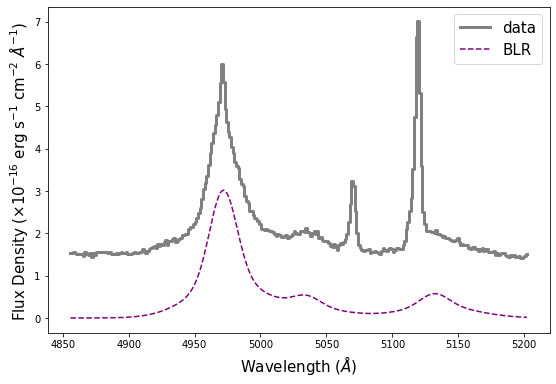

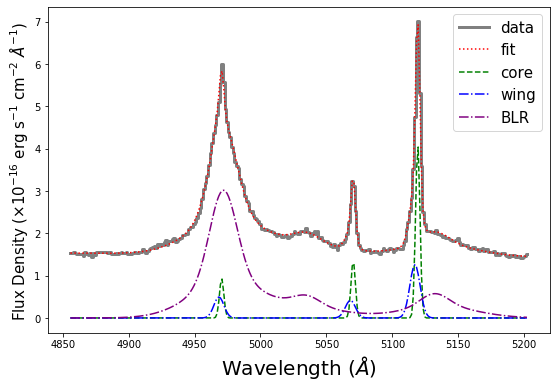

No handles with labels found to put in legend.


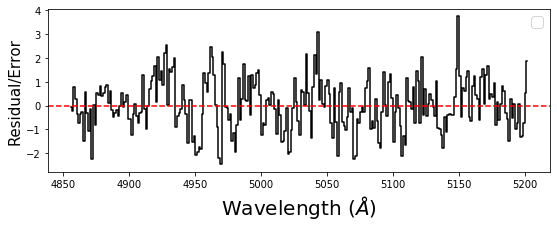

HE1353-1917


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 5.24227096e-01  6.31076440e+00  1.04852688e+04  8.37467618e+01
  1.85740589e-01  7.66894111e-01  1.03046757e+04  4.62371055e+02
  6.23847703e-01  1.29300420e-01  8.21905711e+03  1.34314273e+03
  8.69043383e-01  6.44987423e-02  1.16810767e+04  2.27743374e+03
 -4.78553262e-01  5.94907715e+00  1.80593071e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


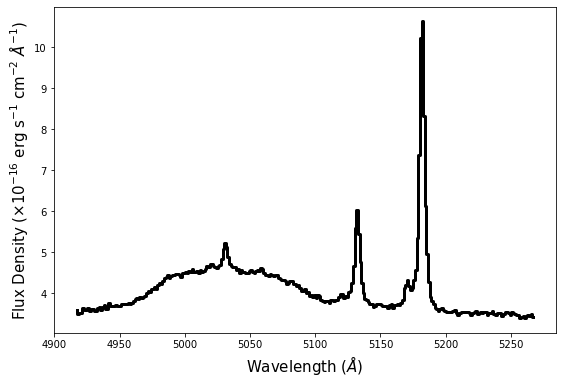

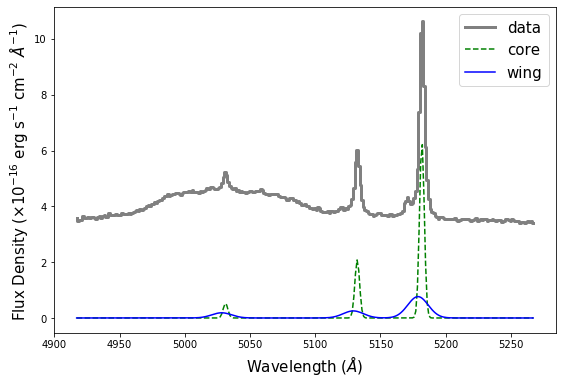

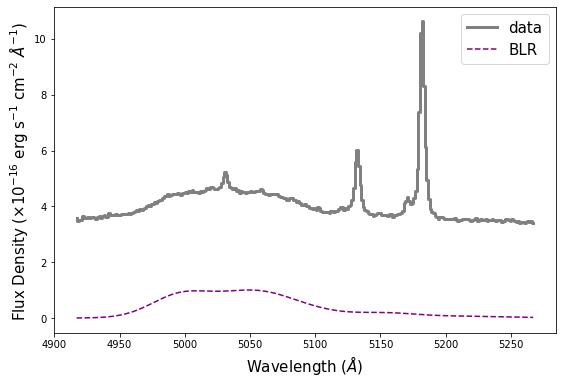

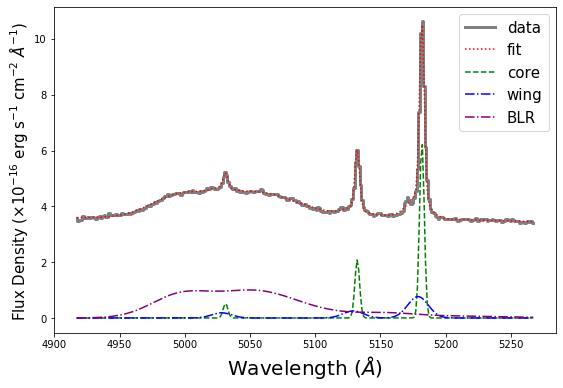

No handles with labels found to put in legend.


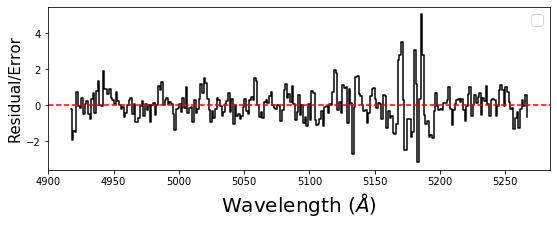

HE2128-0221


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 7.23390244e-01  8.33013110e+00  1.57541212e+04  5.08949367e+01
  8.73406898e-01  2.61060682e+00  1.57198721e+04 -1.37238104e+02
  1.18350769e+00  1.63472850e-01  1.58144564e+04  9.08493795e+02
  0.00000000e+00  0.00000000e+00  1.57440000e+04  1.00000000e+03
 -2.61139992e-01  2.43458916e+00  3.42491415e+01] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


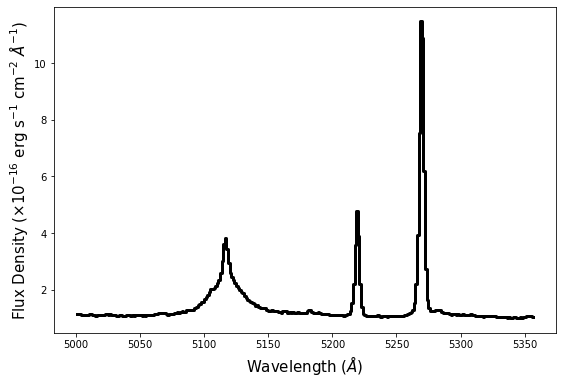

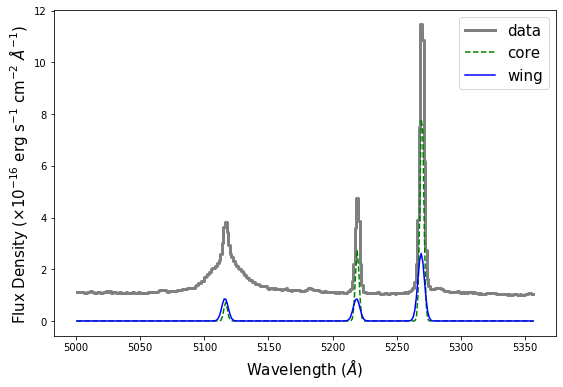

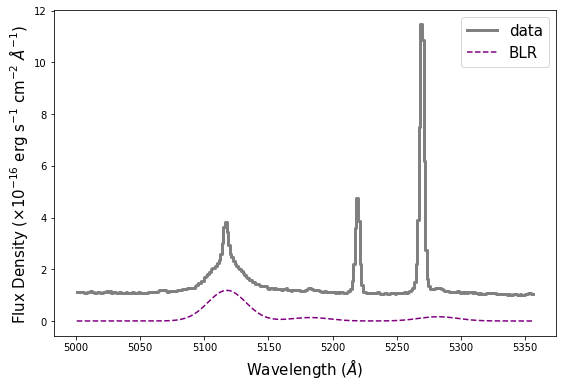

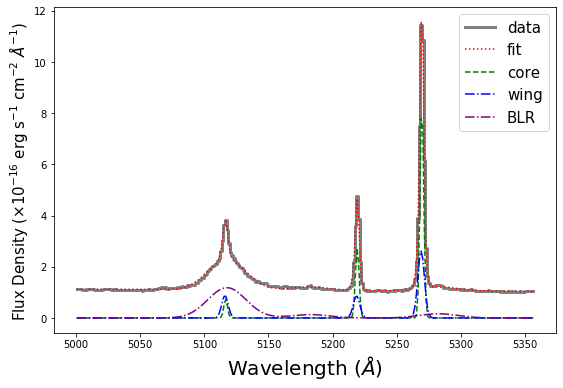

No handles with labels found to put in legend.


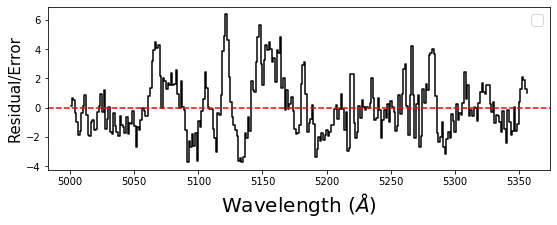

HE2302-0857


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[ 6.64207324e+00  6.34207904e+01  1.41419806e+04  1.98471902e+02
  8.23109649e-02  9.24702658e+00  1.43952870e+04  5.33259201e+02
  5.85611877e+00  5.73696607e-01  1.52743001e+04  1.55125096e+03
  5.97546279e+00  1.67212515e+00  1.24366552e+04  1.90266704e+03
 -5.90601028e+00  4.26646238e+01 -2.53306370e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


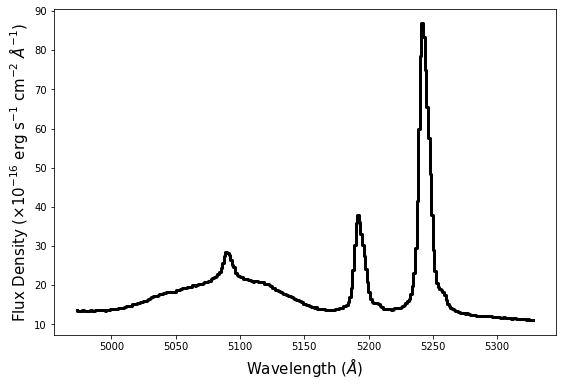

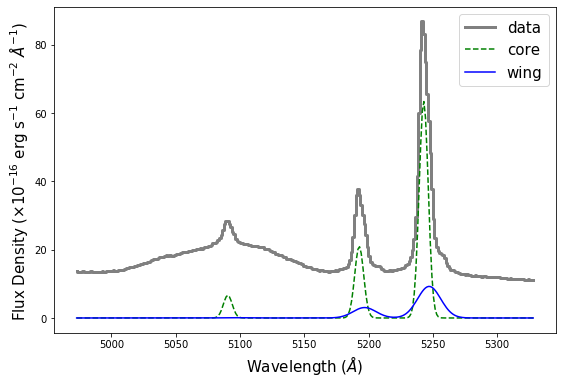

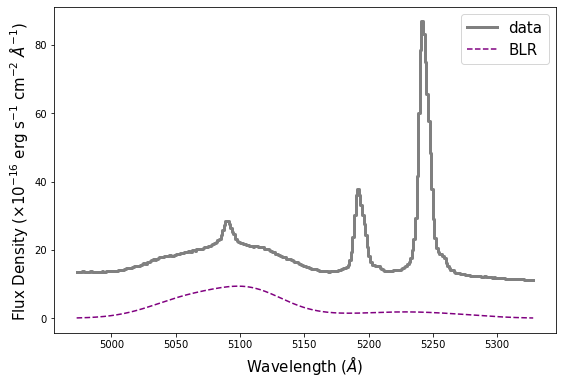

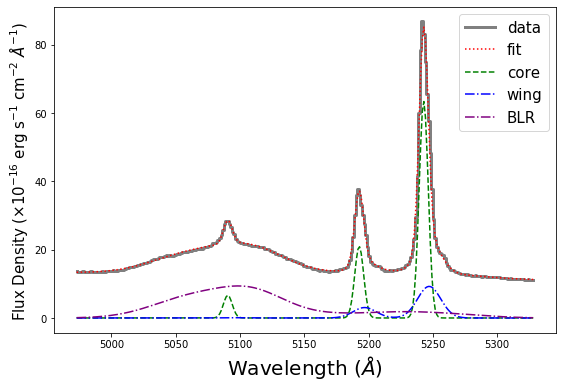

No handles with labels found to put in legend.


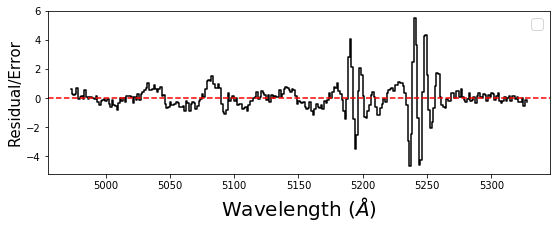

In [22]:
z = {"HE0114-0015":0.04560,"HE0433-1028":0.035550,"HE0934+0119":0.050338,"HE1011-0403":0.058314
    ,"HE1029-1831":0.040261,"HE1108-2813":0.024013,"HE1330-1013":0.022145,"HE1353-1917":0.035021
    ,"HE2128-0221":0.05248,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0114-0015':False,'HE0433-1028':True,'HE0934+0119':True,'HE1011-0403':True,'HE1029-1831':True,'HE1108-2813':False
        ,'HE1330-1013':True,'HE1353-1917':True,'HE2128-0221':False,'HE2302-0857':True}

p_init = {
    
    
    'HE0114-0015':[9.49004680758341, 9.396339789022234, 13674.43099983812, 124.77444289234994, -0.13132264613174283, 0.6277728114102422, 13667.099698829676, 390.65109512546394, 1.7833455112870613, 0.5353495302825251, 13699.168335667626, 1196.487856196145, 0.0, 0.0, 13680.0, 1000.0, -0.23908159151410913, 2.5907549102410443]
         ,'HE0433-1028':[13.498309495582456, 82.0036724538741, 10588.868384256855, 128.10886151673859, 8.456291212671625, 88.97986599729782, 10276.462509524117, 335.30436332023555, 41.2375142887152, 4.2339599172191456, 10497.132697547311, 921.657146942224, 21.28951494125379, 5.680434608820318, 11223.443685503507, 2035.0957234836976, -16.914746969820914, 117.31100961689863]
         ,'HE0934+0119':[8.286278726499965, 49.52415417049359, 15207.052731463187, 72.69407750471247, 4.136346630767625, 22.311137489056893, 15076.66602344673, 168.19078410905178, 21.320016384115423, 3.0418949753222244, 15203.482608797496, 572.0374649611216, 9.11358996524406, 0.5032636297782367, 15199.713290594773, 1485.8783971046369, -3.852104037486194, 33.88683447953653]
         ,'HE1011-0403':[5.679560250554006, 32.08184532672064, 17534.893712734636, 100.02782172331572, 2.7635613631553273, 16.628925824676713, 17313.593001568395, 256.7114554548123, 6.569155042965622, 0.3239135869786792, 17809.568357552558, 1831.8459636923594, 22.59495628469939, 3.0796703343687493, 17676.80483687451, 823.2528416149622, -0.03264532738966647, 21.095443410763075]
         ,'HE1029-1831':[27.454854323789995, 8.289432728444677, 12121.291545072665, 72.18635426939773, 6.585131899061019, 39.883757930100906, 11987.388524295884, 217.16035718745735, 6.062687713586677, 1.9967767300402448, 11965.0962260633, 1623.130402912297, 8.331781018778745, 0.8584218047130702, 12591.074288497652, 859.3010709366221, -3.6820577540187283, 29.468309000290095]
         ,'HE1108-2813':[27.105428799606074, 45.11123832645942, 7169.083504955203, 67.85810214903162, 11.637683835601413, 26.897964592164065, 7051.6747900086675, 236.92504342284278, 16.460639820722413, 4.64152642195189, 7353.615399701936, 1302.6679794875997, 0.0, 0.0, 7200.0, 1000.0, -6.327929811295385, 52.478521898623946]
         ,'HE1330-1013':[3.8218921486267234, 16.189644296556395, 6751.492525381073, 72.72502823229266, 2.1768719448573015, 4.019371418712531, 6610.988554001032, 223.72886433227637, 2.8979687275656847, 1.2687829684053438, 7006.152513832253, 2060.1450409322183, 6.972239192980408, 0.8650183824154536, 6833.816055304659, 673.1740308979133, -3.715326609840787, 24.172854416696296]
         ,'HE1353-1917':[5.236483609050953, 46.45256642216187, 10498.054886325122, 92.87394356771547, 1.0852776957030066, 6.600018061791628, 10303.333663655543, 370.2240269467084, 2.768460085151171, 0.6777145235661884, 8417.494541806254, 1482.6017995516875, 2.684236617141625, 0.18571713021213193, 11786.689880334721, 2054.632082909921, -3.2049989381443917, 29.092611258101567]
         ,'HE2128-0221':[4.2967555930284735, 38.425863788474466, 15756.518753401653, 50.315486306443354, 3.9668680402794236, 11.556876773709128, 15724.475593555811, -140.61480520389588, 5.25913069324259, 0.6418794238600051, 15833.959791548157, 885.7131927955724, 0.0, 0.0, 15744.0, 1000.0, -0.4079330111033193, 6.01099918167622]
         ,'HE2302-0857':[30.08125075371935, 263.4915852081613, 14102.405012933865, 174.78361692454274, 5.234420820727908, 50.4264020928591, 14272.099786366725, 443.97703620906793, 12.465653653818647, 0.580439422201921, 15513.985182493981, 1399.4338046978553, 21.789736064188695, 7.5818140724399505, 12827.562641126544, 2106.3011612081536, -10.076688456785302, 88.0473440529682]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 
        